### Feature Engeneering e Modelagem

O primeiro passo foi fazer a análise exploratória (EDA) dos dados. Agora será feito o pré-processamento e também a modelagem.

Os modelos escolhidos para encontrar o churn foram: Regressão Logística, XGBoost, LightGBM e CatBoost. Eles vão ser testados na base de treino e de acordo com a métrica ROC AUC será escolhido o modelo que será utilizado na base de teste. 

#### Importando as bibliotecas

In [1]:
# Importando a biblioteca para manipulação de bases de dados
import pandas as pd

#Importando a biblioteca para manipulação algébrica
import numpy as np

# Bibliotecas para análise exploratória
import matplotlib.pyplot as plt
import seaborn as sns

# importando as funções Stratified K-Fold e train_test_split
from sklearn.model_selection import train_test_split, StratifiedKFold

# Importando os modelos
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

# importando as funções para calcular a precisão, revocação, precision_recall_auc, roc_auc, medida F1, acurácia e matriz de confusão
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Encoder para tratamento de variáveis categóricas
from category_encoders import CatBoostEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Pipelines
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Importando biblioteca para tunagem de hiperparâmetros
import optuna as opt

# Importando biblioteca para inspecionar o modelo e entender
import shap

# Configurar para não exibir warnings
from warnings import filterwarnings
filterwarnings('ignore')

pd.set_option("display.max_columns", None)

c:\Users\Mestre\Desktop\Intensivão Python\Python Impressionador\ciencia de dados\Universidade de Dados\Projetos\Brazilian E-Commerce Public Dataset by Olist\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Importando a base de dados

Importando a base de dados que foi modificada e salva no arquivo de análise exploratória.

In [109]:
# Importando a base de dados
pedidos = pd.read_csv("../data/data_processed/olist_orders_processed.csv")
pedidos.head()

,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_city,customer_state,order_item_id,product_id,seller_id,price,freight_value,payment_type,payment_installments,product_category_name,review_score,review_answer_timestamp,total,difference_between_delivery_and_estimated_date,recency,churn,order_month,order_year,order_day_of_week,order_name_day_of_week,order_quarter
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,credit_card,1,utilidades_domesticas,4,2017-10-12 03:43:48,38.71,7.0,335,0,10,2017,2,Monday,4
1,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,voucher,1,utilidades_domesticas,4,2017-10-12 03:43:48,38.71,7.0,335,0,10,2017,2,Monday,4
2,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,voucher,1,utilidades_domesticas,4,2017-10-12 03:43:48,38.71,7.0,335,0,10,2017,2,Monday,4
3,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,barreiras,BA,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,118.70,22.76,boleto,1,perfumaria,4,2018-08-08 18:37:50,141.46,5.0,40,0,7,2018,24,Tuesday,3
4,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,vianopolis,GO,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,159.90,19.22,credit_card,3,automotivo,5,2018-08-22 19:07:58,179.12,17.0,26,0,8,2018,8,Wednesday,3


#### Verificando valores duplicados

In [80]:
# Verificando se possui valores duplicados
pedidos[pedidos.duplicated(keep='first')]

,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_city,customer_state,order_item_id,product_id,seller_id,price,freight_value,payment_type,payment_installments,product_category_name,review_score,review_answer_timestamp,total,difference_between_delivery_and_estimated_date,recency,churn,order_month,order_year,order_day_of_week,order_name_day_of_week,order_quarter
2,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,voucher,1,utilidades_domesticas,4,2017-10-12 03:43:48,38.71,7.0,335,0,10,2017,2,Monday,4
23,83018ec114eee8641c97e08f7b4e926f,delivered,2017-10-26 15:54:26,2017-10-26 16:08:14,2017-11-08 22:22:00,2017-11-23,634f09f6075fe9032e6c19609ffe995a,feira de santana,BA,1,c35498fbb4358837ae16850f50c3fd22,70a12e78e608ac31179aea7f8422044b,76.00,16.97,voucher,1,telefonia,4,2017-11-10 01:06:29,92.97,14.0,311,0,10,2017,26,Thursday,4
201,b2bd1f09c1b8a4a36940f6f6e49d5dec,delivered,2018-02-02 16:15:41,2018-02-02 16:36:26,2018-02-20 18:09:29,2018-03-07,f1e0cfbcfd9aebd6d003f6667551a9ae,blumenau,SC,1,eef7436637ac87cad6bf5108284c3413,b33e7c55446eabf8fe1a42d037ac7d6d,199.00,16.14,voucher,1,relogios_presentes,5,2018-02-21 22:22:33,215.14,14.0,212,0,2,2018,2,Friday,1
395,d7f4e2f755cf2f40aa7c39804cfe01c4,delivered,2017-11-26 12:50:56,2017-11-26 13:14:18,2017-12-08 17:02:43,2017-12-20,37d2d1ac62901f9a36cff32ca86c9337,uberlandia,MG,1,cec09725da5ed01471d9a505e7389d37,4d6d651bd7684af3fffabd5f08d12e5a,69.90,20.98,voucher,1,esporte_lazer,5,2017-12-12 00:14:51,90.88,11.0,221,0,11,2017,26,Sunday,4
396,d7f4e2f755cf2f40aa7c39804cfe01c4,delivered,2017-11-26 12:50:56,2017-11-26 13:14:18,2017-12-08 17:02:43,2017-12-20,37d2d1ac62901f9a36cff32ca86c9337,uberlandia,MG,1,cec09725da5ed01471d9a505e7389d37,4d6d651bd7684af3fffabd5f08d12e5a,69.90,20.98,voucher,1,esporte_lazer,5,2017-12-12 00:14:51,90.88,11.0,221,0,11,2017,26,Sunday,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116965,e9d424615d8805614e254bf5c170bef8,delivered,2017-07-05 21:32:47,2017-07-05 21:43:26,2017-07-15 12:03:02,2017-07-31,cb9b7a02c19d2212b2ced9131eb97bd1,rio de janeiro,RJ,1,f1c7f353075ce59d8a6f3cf58f419c9c,37be5a7c751166fbc5f8ccba4119e043,205.00,22.27,voucher,1,cama_mesa_banho,4,2017-07-17 10:30:52,227.27,15.0,424,1,7,2017,5,Wednesday,3
116966,e9d424615d8805614e254bf5c170bef8,delivered,2017-07-05 21:32:47,2017-07-05 21:43:26,2017-07-15 12:03:02,2017-07-31,cb9b7a02c19d2212b2ced9131eb97bd1,rio de janeiro,RJ,1,f1c7f353075ce59d8a6f3cf58f419c9c,37be5a7c751166fbc5f8ccba4119e043,205.00,22.27,voucher,1,cama_mesa_banho,4,2017-07-17 10:30:52,227.27,15.0,424,1,7,2017,5,Wednesday,3
117090,8508c8962494e9606eb5eacaa61c22e2,delivered,2018-01-15 18:07:39,2018-01-15 18:30:48,2018-01-26 12:36:20,2018-02-05,cd191a175691bd3ff0d745dcff5c086a,campo largo,PR,1,6803077179d24889430188e03fafd31a,128639473a139ac0f3e5f5ade55873a5,19.90,12.48,voucher,1,eletronicos,4,2018-01-28 13:28:31,32.38,9.0,230,0,1,2018,15,Monday,1
117153,08d138a502fa05af63ac4005311484f9,delivered,2017-07-18 02:00:48,2017-07-18 02:10:07,2017-08-03 17:23:49,2017-08-17,adaacf4205569e4442d0475628f168b8,aracaju,SE,1,d017a2151d543a9885604dc62a3d9dcc,6560211a19b47992c3666cc44a7e94c0,49.00,21.15,voucher,1,fashion_bolsas_e_acessorios,1,2017-08-13 03:33:54,70.15,13.0,412,1,7,2017,18,Tuesday,3


Foram encontrados 2310 registros duplicados. De acordo com a análise que foi feita, optei por excluir esses registros duplicados para não ter interferência nos modelos.

#### Removendo valores duplicados

In [110]:
# Excluindo os valores duplicados
pedidos = pedidos.drop_duplicates()
pedidos.duplicated().sum()

np.int64(0)

#### Verificando valores ausentes

In [176]:
# Verificando se possui valores vazios em porcentagem
prcentagem_de_vazios = ((pedidos.isna().sum() / pedidos.shape[0]) * 100).round(2)
prcentagem_de_vazios

order_id                                          0.00
order_status                                      0.00
order_purchase_timestamp                          0.00
order_approved_at                                 0.01
order_delivered_customer_date                     2.09
order_estimated_delivery_date                     0.00
customer_unique_id                                0.00
customer_city                                     0.00
customer_state                                    0.00
order_item_id                                     0.00
product_id                                        0.00
seller_id                                         0.00
price                                             0.00
freight_value                                     0.00
payment_type                                      0.00
payment_installments                              0.00
product_category_name                             1.43
review_score                                      0.00
review_ans

De acordo com toda a análise exploratória dos dados percebeu-se que algumas colunas não são tão importantes para prever sobre o churn. Devido isso será excluídas da modelagem. As colunas que estão com valores ausentes são colunas que já iriam ser excluídas. Por isso não será feito nenhum tratamento agora.

#### Verificando valores outliers

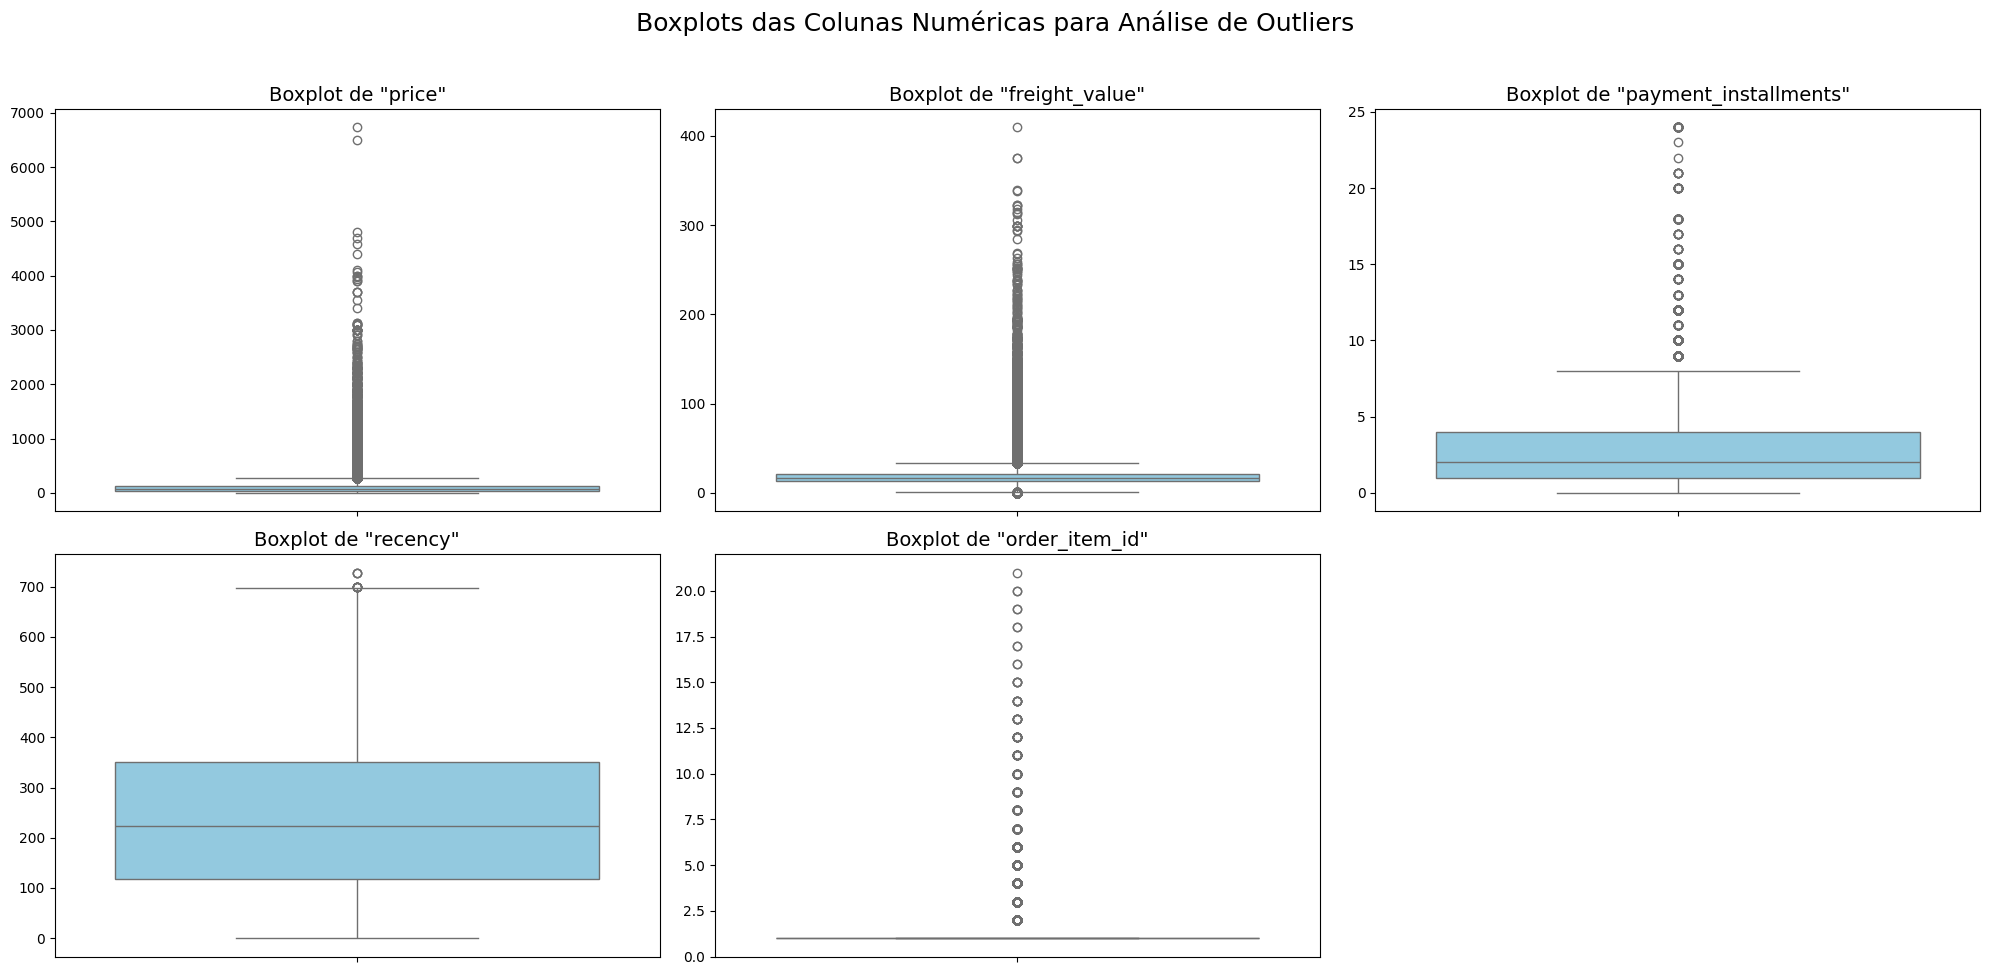

In [94]:
# Pegando as colunas numéricas
colunas_numericas = ['price', 'freight_value', 'payment_installments', 'recency', 'order_item_id']

plt.figure(figsize=(20, 10))
plt.suptitle("Boxplots das Colunas Numéricas para Análise de Outliers", fontsize=18, y=0.97)

# Loop para criar um boxplot para cada coluna
for i, coluna in enumerate(colunas_numericas):
    plt.subplot(2, 3, i + 1)
    
    sns.boxplot(y=pedidos[coluna], color='skyblue')
    plt.title(f'Boxplot de "{coluna}"', fontsize=14)
    plt.ylabel('') 
    plt.xlabel('')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Os valores considerados outliers não ver ser excluído da base. Como são valores de vários produtos, decidi manter esses valores considerados outliers, principalmente para o meu modelo saber lidar com novos valores que podem ser bem maiores ou menores.

### Modelagem

Agora é o momento onde vai ser usado modelos para prever o churn de clientes. Vai ser usando 4 algoritmos para prever e ver qual modelo consegue prever melhor.

#### Divisão da base em treino e teste

Eu optei por separar a base de dados em treino e teste. A base de teste só vai ser usada quando tiver escolhido o modelo e os melhores hiperparâmetros para fazer o teste final. Estou fazendo isso para não correr o risco de ter vazamento de dados. Na base de treino vai ser usado validação cruzada para criar um modelo mais robusto e que não gere overfitting também.

Como estou querendo prever o churn de clientes, a separação das bases vai ser feita de acordo com o ``customer_unique_id``. Isso vai evitar que ocarra vazamento de dados (data leakage), que ocorreria se pedidos do mesmo cliente acabassem no conjunto de treino e no de teste.

O processo será:
- Criar uma lista de clientes únicos e seu status de churn.
- Dividir essa lista de clientes em treino e teste de forma estratificada.
- Usar essas listas de clientes para filtrar e criar os DataFrames finais de treino e teste.
- Depois a modelagem.

In [111]:
# Separação da base de dados em treino e teste

# 1° Passo: Preparar pela separação por cliente
df_customer = pedidos[['customer_unique_id', 'churn']].drop_duplicates()
X_customer = df_customer['customer_unique_id']
y_customer = df_customer['churn']

# 2° Passo: Primeira separação (80% treino e 20% temp)
train_ids, test_ids, _, _ = train_test_split(
    X_customer, y_customer,
    test_size=0.20,
    random_state=42,
    stratify=y_customer
)

# 3° Passo: Criar os dataframes finais
df_train = pedidos[pedidos['customer_unique_id'].isin(train_ids)]
df_test = pedidos[pedidos['customer_unique_id'].isin(test_ids)]

# Agora com esses dataframes finais vai ser gerado a separação de X e y para cada base de treino e teste

# Features que vão permanecer para a modelagem
features = [
    'order_status', 'customer_city', 'customer_state', 'order_item_id', 'price',
    'freight_value', 'payment_type', 'payment_installments', 'review_score', 'total'
]
target = 'churn'

# X_train e y_train para a base de treino
X_train = df_train[features]
y_train = df_train[target]

# X_test e y_test para a base de teste
X_test = df_test[features]
y_test = df_test[target]

print("--- Formato das bases finais para o modelo ---\n")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}\n")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}\n")

--- Formato das bases finais para o modelo ---

X_train shape: (92019, 10)
y_train shape: (92019,)

X_test shape: (23000, 10)
y_test shape: (23000,)



#### Calculando o class weights que vai ser usado nos modelos

In [112]:
# Calculando o class weights
weights = pedidos['churn'].value_counts(1)[0] / pedidos['churn'].value_counts(1)[1]
print(f'Class weights: {weights:.2f}')

Class weights: 3.38


#### Instanciando os modelos

Modelos que vão ser usados:
- <strong>LogisticRegression:</strong> É um modelo estatístico fundamental usado para prever a probabilidade de um resultado binário (churn ou não churn). É rápido, consome poucos recursos e seus resultados são fáveis de interpretar.

- <strong>XGBClassifier:</strong> É um algoritmo avançado e muito popular que constrói milhares de "árvores de decisão" de forma sequencial, onde cada nova árvore corrige os erros da anterior, resultando em um modelo final extremamente poderoso.

- <strong>LGBMClassifier:</strong> É uma implementação de gradient boosting, como o XGBoost, mas otimizada para ser muito mais rápida e eficiente, consumindo menos memória. Ele cresce suas árvores de uma maneira diferente, o que acelera drasticamente o treinamento.

- <strong>CatBoostClassifier:</strong> É outro modelo de gradient boosting que, como o nome indica, foi criado com um foco especial: lidar de forma nativa e inteligente com dados categóricos.

In [113]:
modelo_logistic_regression = LogisticRegression(random_state = 42, class_weight = 'balanced', n_jobs = -1, solver = 'lbfgs', max_iter = 1000)
modelo_XGBoost = XGBClassifier(n_estimators = 500, max_depth = 7, learning_rate = 0.001, n_jobs = -1, random_state = 42, scale_pos_weight = weights, eval_metric = 'auc')
modelo_LightGBM = LGBMClassifier(n_estimators = 500, max_depth = 7, num_leaves = 2**8, learning_rate = 0.001, n_jobs = -1, random_state = 42, class_weight='balanced', verbose = -1)
modelo_catboost = CatBoostClassifier(n_estimators = 500, max_depth = 7, learning_rate = 0.001, scale_pos_weight = weights, random_state = 42, verbose = 0)

#### Criando a função de validação cruzada

Vamos treinar o modelo utilizando a validação cruzada. 

Validação cruzada é uma técnica utilizada para avaliar a capacidade de generalização de um modelo de machine learning, ou seja, quão bem ele performa com dados novos e não vistos. Em vez de simplesmente dividir os dados em um conjunto de treino e um conjunto de teste, a validação cruzada utiliza os dados de forma mais eficiente, treinando e testando o modelo múltiplas vezes em diferentes subconjuntos dos dados.

In [114]:
# Função de validação cruzada para utilizar nos modelos de machine learning
def validacao_cruzada(X, y, modelo, k, threshold, encoder_type='catboost', scaler=False):

    # Separando as colunas categóricas e numéricas
    numerical_cols = X.select_dtypes(include=np.number).columns
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns

    # Pré-processamento para dados numéricos
    if scaler:
        numerical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
    else:
        numerical_transformer = SimpleImputer(strategy='median')
    
    # Pré-processamento para dados categóricos
    if encoder_type == 'onehot':
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ])
    elif encoder_type == 'catboost':
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('catboost', CatBoostEncoder(handle_unknown='value', drop_invariant=True))
        ])
    else:
        raise ValueError("Tipo de encoder desconhecido. Use 'catboost' ou 'onehot'.")
    
    # Pré-processamento de pacotes para dados numéricos e categóricos
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ],
        remainder='passthrough'
    )

    # Criar o pipeline principal que une o pré-processamento e o modelo
    main_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', modelo)
    ])

    # Lista para armazenar as métricas
    precisoes, revocacoes, acuracias, medida_f1, rocs_auc = [], [], [], [], []
    cm_total = np.zeros((2, 2))

    # Lista para armazenar os resultados de cada fold para o gráfico final
    results_list = []

    # Inicializando a função StratifiedKFold para validação cruzada
    folds = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    # Será aplicado o método "split" no objeto folds, que retornará uma lista 
    # com os índices das instâncias que pertencem ao conjunto de treino e 
    # outra com os índices das instâncias que pertencem ao conjunto de teste
    for fold_n, (train_index, val_index) in enumerate(folds.split(X, y)):
        print("=-"*7 + f"Fold: {fold_n + 1}" + "=-"*7)

        # Dividindo os dados em treino e teste do fold atual
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

        # Treina o pipeline inteiro (pré-processamento + modelo) com os dados de treino do fold
        main_pipeline.fit(X_train_fold, y_train_fold)

        # Faz predições no conjunto de validação do fold
        # O Pipeline aplica automaticamente as transformações aprendidas da base de treino
        y_pred_proba = main_pipeline.predict_proba(X_val_fold)[:, 1]

        # Aplicando o threshold para obter a previsão do modelo
        y_pred = np.where(y_pred_proba > threshold, 1, 0)

        # Calcular e armazenar as métricas
        precisao_score = precision_score(y_val_fold, y_pred, zero_division=0)
        revocacao_score = recall_score(y_val_fold, y_pred)
        acuracia_score = accuracy_score(y_val_fold, y_pred)
        f1score = f1_score(y_val_fold, y_pred)
        roc_auc = roc_auc_score(y_val_fold, y_pred_proba)

        precisoes.append(precisao_score)
        revocacoes.append(revocacao_score)
        acuracias.append(acuracia_score)
        medida_f1.append(f1score)
        rocs_auc.append(roc_auc)

        cm_total += confusion_matrix(y_val_fold, y_pred)

        # Criar um DataFrame com os resultados deste fold e adicioná-lo à lista
        fold_df = pd.DataFrame({
            'y_real': y_val_fold,
            'score_modelo': y_pred_proba
        })
        results_list.append(fold_df)

        # Exibir as métricas do fold
        print(f"Precisão: {precisao_score:.3f} | Revocação: {revocacao_score:.3f} | F1-Score: {f1score:.3f} | ROC AUC: {roc_auc:.3f}")

    # Transformando as listas em arrays para fazer operações matemáticas
    precisoes = np.array(precisoes)
    revocacoes = np.array(revocacoes)
    acuracias = np.array(acuracias)
    medida_f1 = np.array(medida_f1)
    rocs_auc = np.array(rocs_auc)

    # --- 4. EXIBIR OS RESULTADOS FINAIS ---
    print("\n" + "=-"*6 + " Exibindo a média das métricas obtidas " + "-="*6)
    print(f"Média da precisão: {np.mean(precisoes):.3f} +/- {np.std(precisoes):.3f}")
    print(f"Média da revocação: {np.mean(revocacoes):.3f} +/- {np.std(revocacoes):.3f}")
    print(f"Média da acurácia: {np.mean(acuracias):.3f} +/- {np.std(acuracias):.3f}")
    print(f"Média da Medida F1: {np.mean(medida_f1):.3f} +/- {np.std(medida_f1):.3f}")
    print(f"Média da ROC AUC: {np.mean(rocs_auc):.3f} +/- {np.std(rocs_auc):.3f}")

    # Consolidar os resultados de score dos folds
    final_results_df = pd.concat(results_list, ignore_index=True)

    # Gráfico da matriz de confusão, distribuição e curva ROC, lado a lado
    fig, axes = plt.subplots(1, 3, figsize=(22, 6)) # ALTERADO AQUI: 1 linha, 3 colunas
    fig.suptitle('Análise Consolidada da Validação Cruzada', fontsize=18)

    # 1. Matriz de Confusão Acumulada
    sns.heatmap(cm_total, annot=True, fmt=".0f", cmap='Blues', ax=axes[0], xticklabels=['Não Churn', 'Churn'], yticklabels=['Não Churn', 'Churn'])
    axes[0].set_title("Matriz de Confusão Acumulada", fontsize=14)
    axes[0].set_ylabel('Verdadeiro')
    axes[0].set_xlabel('Previsto')

    # 2. Distribuição de Scores do Modelo
    sns.kdeplot(final_results_df[final_results_df['y_real'] == 0]['score_modelo'], label='Não Churn (y=0)', fill=True, ax=axes[1])
    sns.kdeplot(final_results_df[final_results_df['y_real'] == 1]['score_modelo'], label='Churn (y=1)', fill=True, ax=axes[1])
    axes[1].set_title("Distribuição de Scores do Modelo", fontsize=14)
    axes[1].set_xlabel("Score (Probabilidade de Churn)")
    axes[1].set_ylabel("Densidade")
    axes[1].legend()
    axes[1].grid(True, linestyle='--', alpha=0.6)

    # 3. Curvas ROC por Fold
    for i, fold_results in enumerate(results_list):
        y_real_fold = fold_results['y_real']
        score_modelo_fold = fold_results['score_modelo']
        fpr, tpr, _ = roc_curve(y_real_fold, score_modelo_fold)
        auc_score = roc_auc_score(y_real_fold, score_modelo_fold)
        axes[2].plot(fpr, tpr, lw=2, alpha=0.7, label=f'Fold {i+1} (AUC = {auc_score:.2f})')

    axes[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
    axes[2].set_title('Curvas ROC por Fold', fontsize=14)
    axes[2].set_xlabel('Taxa de Falsos Positivos')
    axes[2].set_ylabel('Taxa de Verdadeiros Positivos')
    axes[2].legend()
    axes[2].grid(True, linestyle='--', alpha=0.6)

    # Ajusta o layout para evitar sobreposição
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

##### Agora vai ser usado a função de validação cruzada para cada modelo que já foi instanciado

#### Modelo Regressão Logística

Como a Regressão Logística é um modelo linear e não é tão complexo, não vai ser usado o ``CatBoostEncoder``, pois pode correr o risco de ter vazamento de dados. No seu lugar vai ser usado o ``OneHotEncoder``.

Na Regressão Logística também vai ser feito a padronização dos dados numéricos utilizando o ``StandardScaler``.

=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
Precisão: 0.273 | Revocação: 0.492 | F1-Score: 0.351 | ROC AUC: 0.573
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
Precisão: 0.274 | Revocação: 0.500 | F1-Score: 0.354 | ROC AUC: 0.572
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
Precisão: 0.277 | Revocação: 0.502 | F1-Score: 0.357 | ROC AUC: 0.585
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
Precisão: 0.272 | Revocação: 0.501 | F1-Score: 0.352 | ROC AUC: 0.577
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-
Precisão: 0.274 | Revocação: 0.504 | F1-Score: 0.355 | ROC AUC: 0.580

=-=-=-=-=-=- Exibindo a média das métricas obtidas -=-=-=-=-=-=
Média da precisão: 0.274 +/- 0.002
Média da revocação: 0.500 +/- 0.004
Média da acurácia: 0.584 +/- 0.003
Média da Medida F1: 0.354 +/- 0.002
Média da ROC AUC: 0.578 +/- 0.005


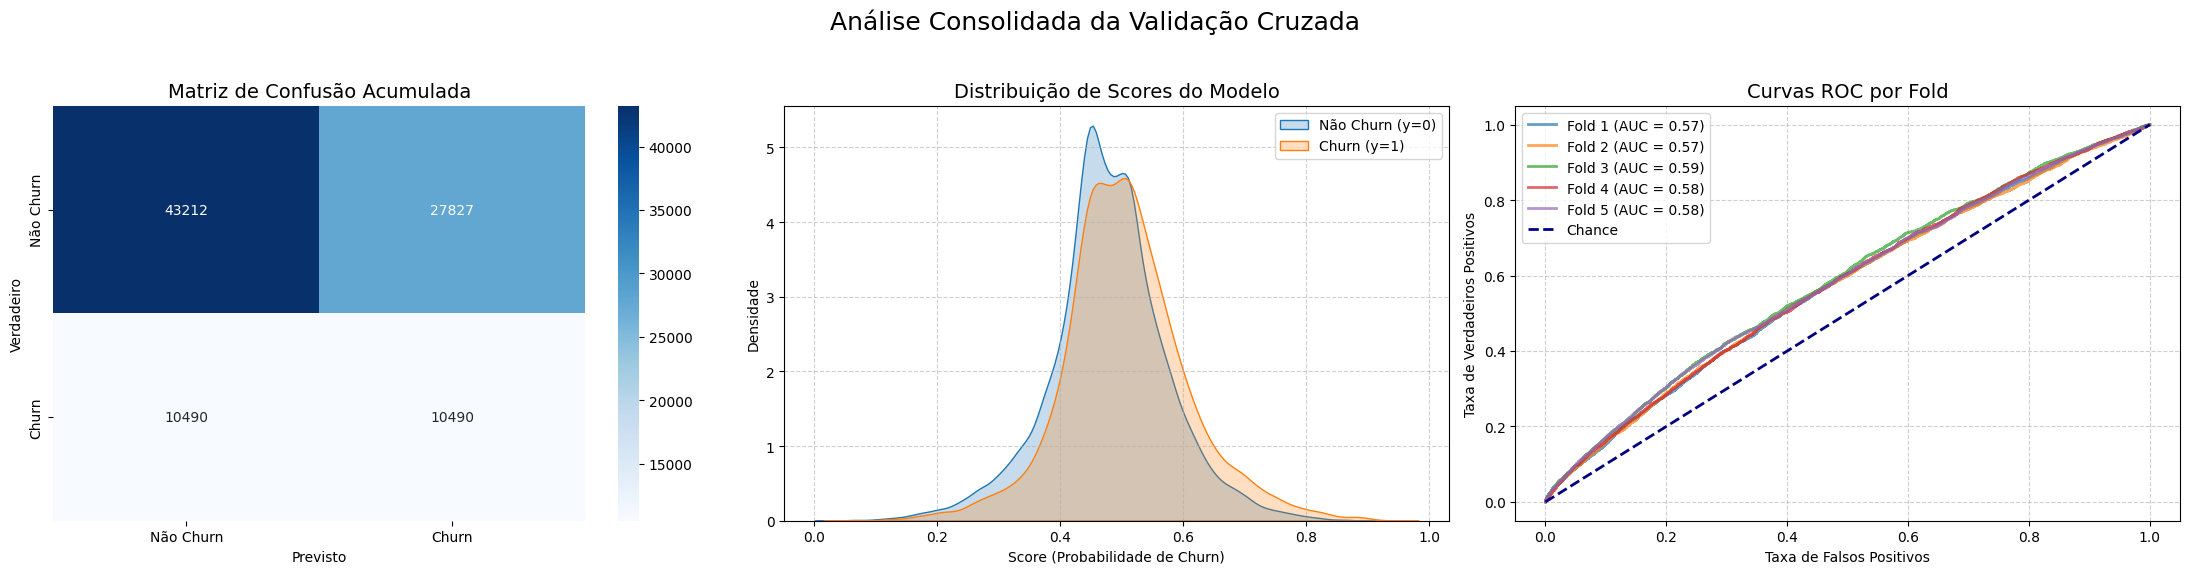

In [44]:
# Usando a função de validação cruzada com o modelo de regressão logística
validacao_cruzada(X_train, y_train, modelo_logistic_regression, k=5, threshold=0.5, encoder_type='onehot', scaler=True)

- Como estamos priorizando a métrica ROC AUC, percebemos que o modelo não aprendeu muito bem.
- Ele está prevendo churn clientes que não são churn, temos 27827 falsos positivos, que no caso previu churn e não é churn.
- O modelo também previu 10490 clientes como não churn e era churn, os falsos negativos.

#### Modelo XGBoost

=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
Precisão: 0.321 | Revocação: 0.749 | F1-Score: 0.449 | ROC AUC: 0.702
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
Precisão: 0.322 | Revocação: 0.719 | F1-Score: 0.445 | ROC AUC: 0.696
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
Precisão: 0.329 | Revocação: 0.711 | F1-Score: 0.450 | ROC AUC: 0.703
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
Precisão: 0.318 | Revocação: 0.709 | F1-Score: 0.439 | ROC AUC: 0.685
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-
Precisão: 0.326 | Revocação: 0.695 | F1-Score: 0.443 | ROC AUC: 0.698

=-=-=-=-=-=- Exibindo a média das métricas obtidas -=-=-=-=-=-=
Média da precisão: 0.323 +/- 0.004
Média da revocação: 0.717 +/- 0.018
Média da acurácia: 0.593 +/- 0.009
Média da Medida F1: 0.445 +/- 0.004
Média da ROC AUC: 0.697 +/- 0.006


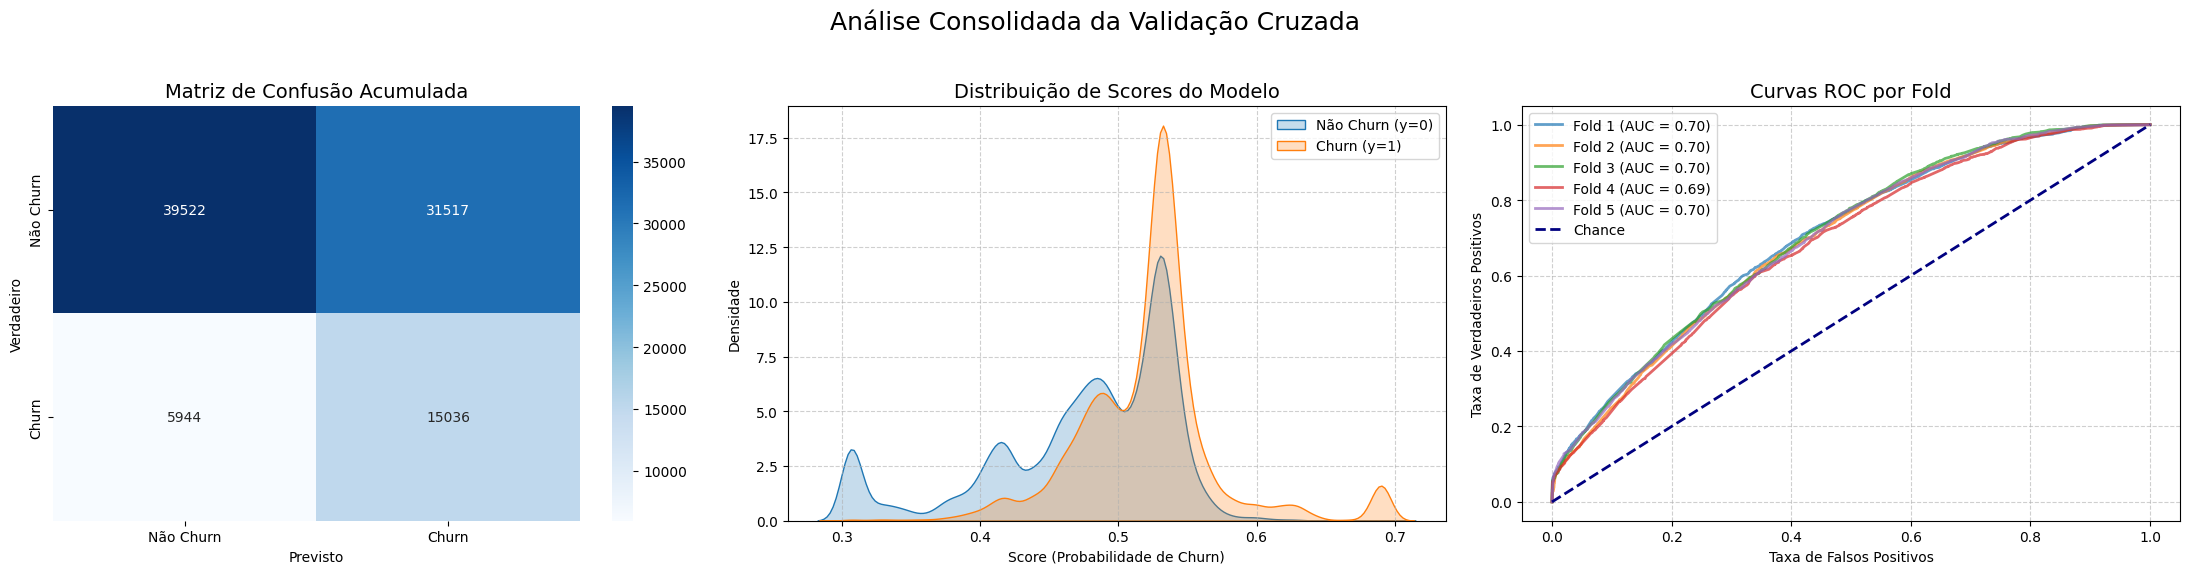

In [45]:
# Usando a função de validação cruzada com o modelo XGBoost
validacao_cruzada(X_train, y_train, modelo_XGBoost, k=5, threshold=0.5, encoder_type='catboost', scaler=False)

- O modelo XGBoost se saiu bem melhor que a Regressão Logística, sua ROC AUC deu 0.697.
- Ele acabou prevendo muitos clientes como churn e que não são churn.
- Em relação a Regressão Logística ele melhorou na precisão. Ele previu modelos como não churn e que eram churn. Em relação a regressão esse valor diminuiu e isso é o que queremos também.

#### Modelo LightGBM

=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
Precisão: 0.325 | Revocação: 0.733 | F1-Score: 0.450 | ROC AUC: 0.703
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
Precisão: 0.320 | Revocação: 0.702 | F1-Score: 0.439 | ROC AUC: 0.695
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
Precisão: 0.321 | Revocação: 0.722 | F1-Score: 0.445 | ROC AUC: 0.698
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
Precisão: 0.317 | Revocação: 0.701 | F1-Score: 0.437 | ROC AUC: 0.686
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-
Precisão: 0.324 | Revocação: 0.695 | F1-Score: 0.442 | ROC AUC: 0.697

=-=-=-=-=-=- Exibindo a média das métricas obtidas -=-=-=-=-=-=
Média da precisão: 0.321 +/- 0.003
Média da revocação: 0.711 +/- 0.014
Média da acurácia: 0.592 +/- 0.004
Média da Medida F1: 0.443 +/- 0.005
Média da ROC AUC: 0.696 +/- 0.005


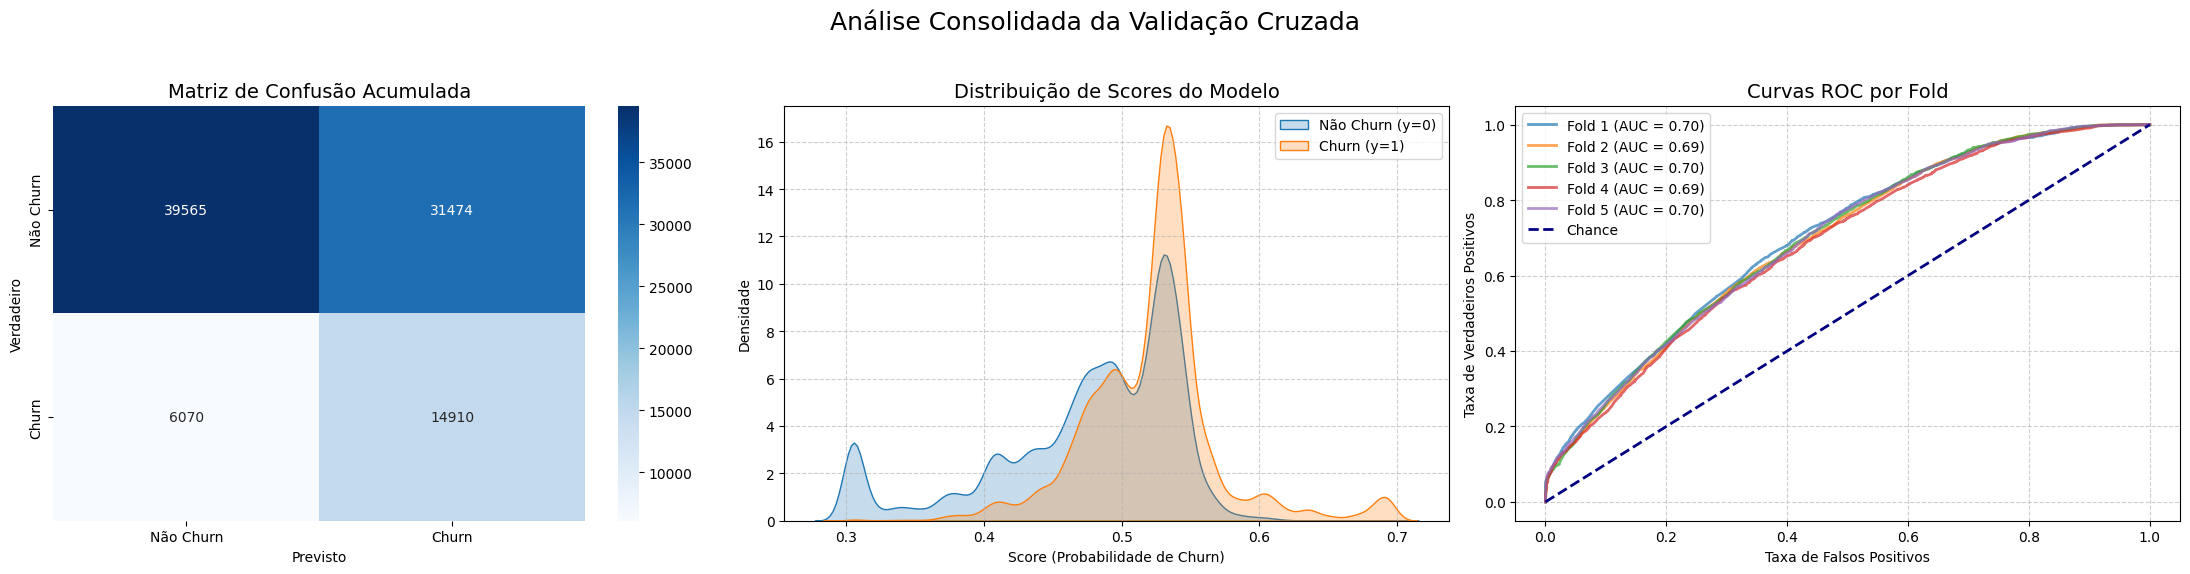

In [46]:
# Usando a função de validação cruzada com o modelo LightGBM
validacao_cruzada(X_train, y_train, modelo_LightGBM, k=5, threshold=0.5, encoder_type='catboost', scaler=False)

- O modelo LightBoost ficou parecido com o XGBoost, deu um valor um pouco menor na métrica ROC AUC, 0.696.
- Mas ele acabou aumentando o número de clientes que era churn e o modelo previu como não churn.

#### Modelo CatBoost

=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
Precisão: 0.295 | Revocação: 0.644 | F1-Score: 0.405 | ROC AUC: 0.651
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
Precisão: 0.290 | Revocação: 0.649 | F1-Score: 0.401 | ROC AUC: 0.643
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
Precisão: 0.293 | Revocação: 0.647 | F1-Score: 0.404 | ROC AUC: 0.657
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
Precisão: 0.285 | Revocação: 0.620 | F1-Score: 0.390 | ROC AUC: 0.637
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-
Precisão: 0.294 | Revocação: 0.633 | F1-Score: 0.402 | ROC AUC: 0.650

=-=-=-=-=-=- Exibindo a média das métricas obtidas -=-=-=-=-=-=
Média da precisão: 0.291 +/- 0.004
Média da revocação: 0.639 +/- 0.011
Média da acurácia: 0.564 +/- 0.005
Média da Medida F1: 0.400 +/- 0.005
Média da ROC AUC: 0.648 +/- 0.007


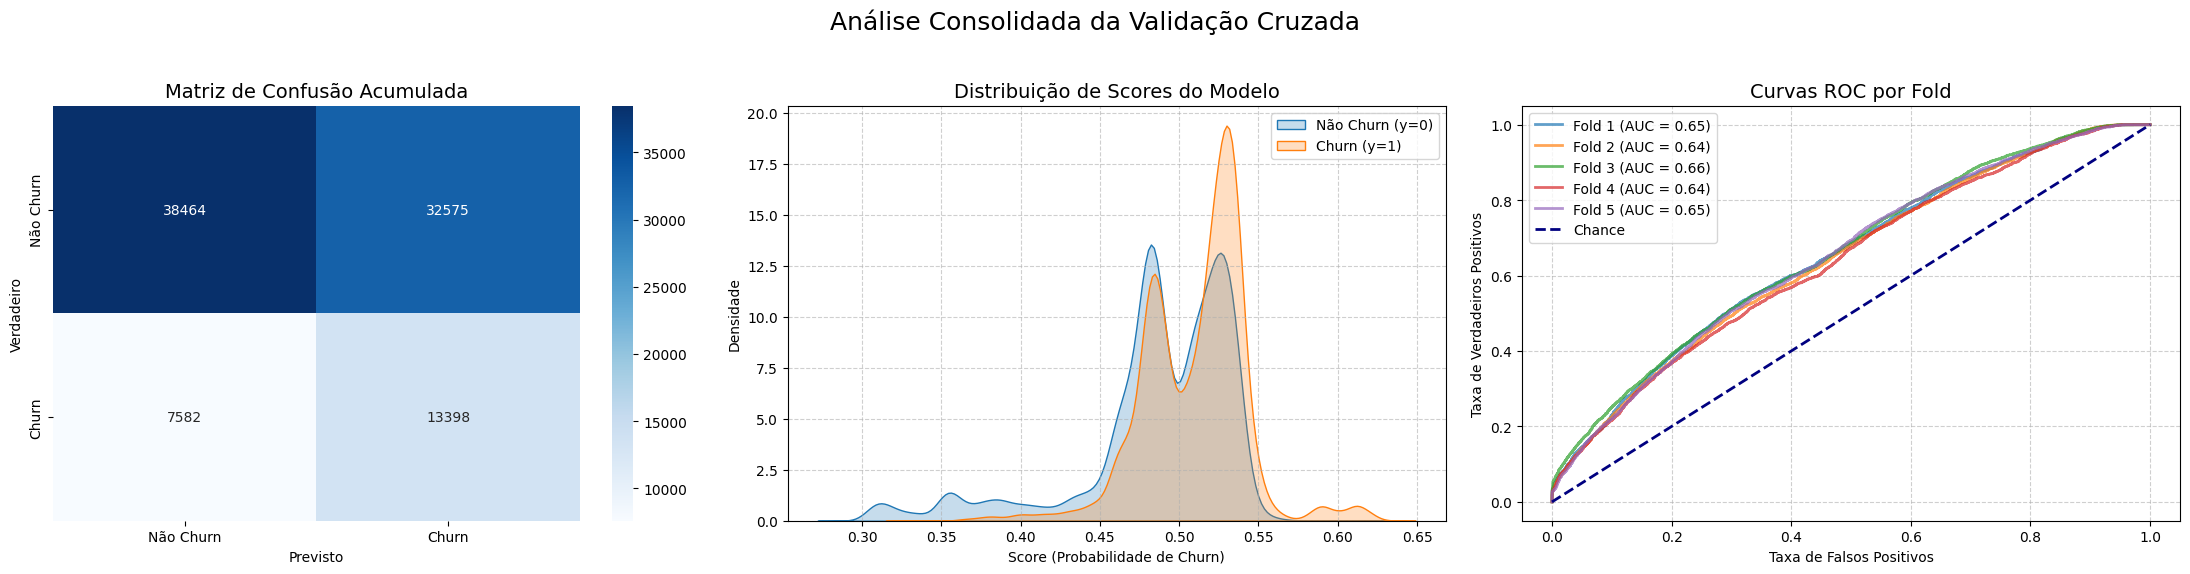

In [47]:
# Usando a função de validação cruzada com o modelo CatBoost
validacao_cruzada(X_train, y_train, modelo_catboost, k=5, threshold=0.5, encoder_type='catboost', scaler=False)

- O CatBoost ficou melhor que a regressão mas pior que os outros modelos. Sua métrica ROC AUC ficou em 0.648.
- Também teve um aumento de valores que de churn que o modelo previu que não era churn.

### Tunagem de Hiperparâmetros

Vamos fazer o processo de tunagem de hiperparâmetro, que é um processo de otimização que consiste em encontrar a combinação ideal de configurações para um determinado algoritmo de aprendizado de máquina. Diferente dos parâmetros do modelo, que são aprendidos durante o treinamento a partir dos dados (como os pesos em uma rede neural), os hiperparâmetros são definidos antes do início do processo de treinamento e ditam o comportamento do algoritmo.

In [115]:
# Função para fazer a tunagem de hiperparâmetros dos modelos
def tunagem_hiperparametros(trial, modelo, X, y, k=5, threshold=0.5, scaler=False, encoder_type='catboost', weights = weights):

    # Tunagem de hiperparâmetros do modelo de Regressão Logística
    if modelo == 'logistic':
        # Parâmetro C (Força de regularização inversa): Buscamos em escala logarítmica
        param_C = trial.suggest_float('C', 1e-4, 1e2, log=True)

        # Parâmetro solver e penalty: Eles são dependentes
        solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
        if solver == 'liblinear':
            penalty = trial.suggest_categorical(f'penalty_{solver}', ['l1', 'l2'])
        else:
            penalty = trial.suggest_categorical(f'penalty_{solver}', ['l1', 'l2', 'elasticnet'])
        
        # Para 'elasticnet', precisamos de l1_ratio. Para os outros, não.
        l1_ratio = None
        if penalty == 'elasticnet':
            l1_ratio = trial.suggest_float('l1_ratio', 0.1, 0.9)

        model = LogisticRegression(C=param_C, solver=solver, penalty=penalty, l1_ratio=l1_ratio,
                                   random_state = 42, class_weight = 'balanced', n_jobs = -1, max_iter = 1000)
    
    # Tunagem de hiperparâmetros do modelo XGBoost
    elif modelo == 'xgboost':
        min_child_weight = trial.suggest_int('min_child_weight', 1, 20)
        learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
        subsample = trial.suggest_float('subsample', 0, 1)
        max_depth = trial.suggest_int('max_depth', 1, 10)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0, 1, step=0.1)
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)

        model = XGBClassifier(learning_rate = learning_rate, max_depth = max_depth, subsample = subsample, colsample_bytree = colsample_bytree,
                                      min_child_weight = min_child_weight, n_estimators = n_estimators, n_jobs = -1, random_state = 0, 
                                      scale_pos_weight = weights, eval_metric = 'error')

    # Tunagem de hiperparâmetros do modelo LightGBM
    elif modelo == 'lightgbm':
        num_leaves = trial.suggest_int('num_leaves', 2, 2**10)
        min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 100)
        learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
        subsample = trial.suggest_float('subsample', 0, 1)
        max_depth = trial.suggest_int('max_depth', 1, 10)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1, step=0.1)
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
       
        model = LGBMClassifier(n_estimators = 500, max_depth=max_depth, num_leaves=num_leaves, learning_rate=learning_rate, min_data_in_leaf=min_data_in_leaf,
                               subsample=subsample, colsample_bytree=colsample_bytree, n_jobs = -1, random_state = 42, 
                               class_weight='balanced', verbose = -1)

    # Tunagem de hiperparâmetros do modelo CatBoost
    elif modelo == 'catboost':
        min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 100)
        learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
        subsample = trial.suggest_float('subsample', 0, 1)
        max_depth = trial.suggest_int('max_depth', 1, 10)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1, step=0.1)
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)

        model = CatBoostClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, scale_pos_weight = weights, 
                                   min_data_in_leaf=min_data_in_leaf, subsample=subsample, colsample_bylevel=colsample_bytree, 
                                   random_state = 42, verbose = 0)

    # Separando as colunas categóricas e numéricas
    numerical_cols = X.select_dtypes(include=np.number).columns
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns

    # Pré-processamento para dados numéricos
    if scaler:
        numerical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
    else:
        numerical_transformer = SimpleImputer(strategy='median')
    
    # Pré-processamento para dados categóricos
    if encoder_type == 'onehot':
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ])
    elif encoder_type == 'catboost':
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('catboost', CatBoostEncoder(handle_unknown='value', drop_invariant=True))
        ])
    else:
        raise ValueError("Tipo de encoder desconhecido. Use 'catboost' ou 'onehot'.")
    
    # Pré-processamento de pacotes para dados numéricos e categóricos
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ],
        remainder='passthrough'
    )

    # Criar o pipeline principal que une o pré-processamento e o modelo
    main_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

     # Inicializando a função StratifiedKFold para validação cruzada
    folds = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    # A lista da métrica revocações
    revocacoes = []

    # Será aplicado o método "split" no objeto folds, que retornará uma lista 
    # com os índices das instâncias que pertencem ao conjunto de treino e 
    # outra com os índices das instâncias que pertencem ao conjunto de teste
    for fold_n, (train_index, val_index) in enumerate(folds.split(X, y)):
        print("=-"*7 + f"Fold: {fold_n + 1}" + "=-"*7)

        # Dividindo os dados em treino e teste do fold atual
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

        # Treina o pipeline inteiro (pré-processamento + modelo) com os dados de treino do fold
        main_pipeline.fit(X_train_fold, y_train_fold)

        # Faz predições no conjunto de validação do fold
        # O Pipeline aplica automaticamente as transformações aprendidas da base de treino
        y_pred_proba = main_pipeline.predict_proba(X_val_fold)[:, 1]

        # Aplicando o threshold para obter a previsão do modelo
        y_pred = np.where(y_pred_proba > threshold, 1, 0)

        # Calcular e armazenar a métrica de revocação
        revocacao_score = recall_score(y_val_fold, y_pred)

        revocacoes.append(revocacao_score)

    # Transformando a lista de revocção em array para fazer operações matemáticas
    revocacoes = np.array(revocacoes)

    # Calculando a média de revocação
    media_revocacao = np.mean(revocacoes)

    return media_revocacao

#### Fazendo a Tunagem de Hiperparâmetros para a Regressão Logística

In [116]:
study = opt.create_study(direction='maximize')
study.optimize(
    lambda trial: tunagem_hiperparametros(
        trial,
        modelo='logistic',
        X=X_train,
        y=y_train,
        k=5,
        threshold=0.5,
        scaler=True,
        encoder_type='onehot',
        weights=weights
    ),
    n_trials=50
)

[I 2025-07-11 23:07:13,140] A new study created in memory with name: no-name-9d3c7adb-7fa8-4239-a3f2-8260aed440a0


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-11 23:07:23,475] Trial 0 finished with value: 0.42654909437559585 and parameters: {'C': 0.0007249720094013277, 'solver': 'liblinear', 'penalty_liblinear': 'l1'}. Best is trial 0 with value: 0.42654909437559585.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 00:47:15,821] Trial 1 finished with value: 0.5119637750238322 and parameters: {'C': 1.028141721480038, 'solver': 'saga', 'penalty_saga': 'elasticnet', 'l1_ratio': 0.7874434290615663}. Best is trial 1 with value: 0.5119637750238322.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 16:51:07,714] Trial 2 finished with value: 0.5089132507149667 and parameters: {'C': 1.2417104894629138, 'solver': 'saga', 'penalty_saga': 'elasticnet', 'l1_ratio': 0.7478593851185307}. Best is trial 1 with value: 0.5119637750238322.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 16:57:42,432] Trial 3 finished with value: 0.540514775977121 and parameters: {'C': 0.005127485718610878, 'solver': 'saga', 'penalty_saga': 'l1'}. Best is trial 3 with value: 0.540514775977121.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 16:57:47,023] Trial 4 finished with value: 0.4520495710200191 and parameters: {'C': 0.0022935343969246506, 'solver': 'liblinear', 'penalty_liblinear': 'l1'}. Best is trial 3 with value: 0.540514775977121.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 17:03:02,457] Trial 5 finished with value: 0.49761677788369874 and parameters: {'C': 4.47964218078543, 'solver': 'saga', 'penalty_saga': 'l2'}. Best is trial 3 with value: 0.540514775977121.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 17:04:05,836] Trial 6 finished with value: 0.5497616777883699 and parameters: {'C': 0.17813380160994172, 'solver': 'liblinear', 'penalty_liblinear': 'l1'}. Best is trial 6 with value: 0.5497616777883699.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 17:50:20,438] Trial 7 finished with value: 0.530886558627264 and parameters: {'C': 0.32863138280357457, 'solver': 'saga', 'penalty_saga': 'elasticnet', 'l1_ratio': 0.577737428826449}. Best is trial 6 with value: 0.5497616777883699.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 17:56:05,820] Trial 8 finished with value: 0.5503336510962822 and parameters: {'C': 0.004350665344145268, 'solver': 'saga', 'penalty_saga': 'l2'}. Best is trial 8 with value: 0.5503336510962822.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 17:59:27,719] Trial 9 finished with value: 0.5196377502383223 and parameters: {'C': 0.6572673116139891, 'solver': 'liblinear', 'penalty_liblinear': 'l1'}. Best is trial 8 with value: 0.5503336510962822.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 18:01:09,818] Trial 10 finished with value: 0.5414680648236416 and parameters: {'C': 0.00010932957000377428, 'solver': 'saga', 'penalty_saga': 'l2'}. Best is trial 8 with value: 0.5503336510962822.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 18:01:17,580] Trial 11 finished with value: 0.548045757864633 and parameters: {'C': 0.028230942576549463, 'solver': 'liblinear', 'penalty_liblinear': 'l2'}. Best is trial 8 with value: 0.5503336510962822.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 18:02:31,024] Trial 12 finished with value: 0.4901811248808389 and parameters: {'C': 58.06222088983364, 'solver': 'liblinear', 'penalty_liblinear': 'l2'}. Best is trial 8 with value: 0.5503336510962822.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 18:03:03,496] Trial 13 finished with value: 0.5557197330791229 and parameters: {'C': 0.07753206691539616, 'solver': 'liblinear', 'penalty_liblinear': 'l1'}. Best is trial 13 with value: 0.5557197330791229.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 18:07:52,382] Trial 14 finished with value: 0.5474261201143947 and parameters: {'C': 0.03127777512021056, 'solver': 'saga', 'penalty_saga': 'l2'}. Best is trial 13 with value: 0.5557197330791229.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 18:08:06,647] Trial 15 finished with value: 0.5526215443279314 and parameters: {'C': 0.020196773193221607, 'solver': 'liblinear', 'penalty_liblinear': 'l1'}. Best is trial 13 with value: 0.5557197330791229.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 18:08:21,376] Trial 16 finished with value: 0.5551477597712107 and parameters: {'C': 0.035440428601641, 'solver': 'liblinear', 'penalty_liblinear': 'l1'}. Best is trial 13 with value: 0.5557197330791229.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 18:17:17,168] Trial 17 finished with value: 0.4928503336510962 and parameters: {'C': 26.91724413743464, 'solver': 'liblinear', 'penalty_liblinear': 'l1'}. Best is trial 13 with value: 0.5557197330791229.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 18:17:52,342] Trial 18 finished with value: 0.5542897998093423 and parameters: {'C': 0.09741635811317166, 'solver': 'liblinear', 'penalty_liblinear': 'l1'}. Best is trial 13 with value: 0.5557197330791229.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 18:18:00,042] Trial 19 finished with value: 0.5380838894184938 and parameters: {'C': 0.0763715608749229, 'solver': 'liblinear', 'penalty_liblinear': 'l2'}. Best is trial 13 with value: 0.5557197330791229.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 18:26:40,474] Trial 20 finished with value: 0.486558627264061 and parameters: {'C': 6.203458304904151, 'solver': 'liblinear', 'penalty_liblinear': 'l1'}. Best is trial 13 with value: 0.5557197330791229.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 18:27:02,920] Trial 21 finished with value: 0.5555290753098188 and parameters: {'C': 0.0675106481622351, 'solver': 'liblinear', 'penalty_liblinear': 'l1'}. Best is trial 13 with value: 0.5557197330791229.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 18:27:19,383] Trial 22 finished with value: 0.5302192564346997 and parameters: {'C': 0.008975993734964228, 'solver': 'liblinear', 'penalty_liblinear': 'l1'}. Best is trial 13 with value: 0.5557197330791229.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 18:27:48,517] Trial 23 finished with value: 0.5555290753098189 and parameters: {'C': 0.07167681864106025, 'solver': 'liblinear', 'penalty_liblinear': 'l1'}. Best is trial 13 with value: 0.5557197330791229.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 18:29:30,805] Trial 24 finished with value: 0.5424213536701621 and parameters: {'C': 0.27732160415963863, 'solver': 'liblinear', 'penalty_liblinear': 'l1'}. Best is trial 13 with value: 0.5557197330791229.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 18:29:34,350] Trial 25 finished with value: 0.38894184938036225 and parameters: {'C': 0.001640094275798375, 'solver': 'liblinear', 'penalty_liblinear': 'l1'}. Best is trial 13 with value: 0.5557197330791229.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 18:29:44,411] Trial 26 finished with value: 0.536653956148713 and parameters: {'C': 0.08397227441532934, 'solver': 'liblinear', 'penalty_liblinear': 'l2'}. Best is trial 13 with value: 0.5557197330791229.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 18:36:53,728] Trial 27 finished with value: 0.4901811248808389 and parameters: {'C': 1.9307485160915105, 'solver': 'liblinear', 'penalty_liblinear': 'l1'}. Best is trial 13 with value: 0.5557197330791229.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 18:37:08,321] Trial 28 finished with value: 0.5349380362249762 and parameters: {'C': 0.01016549742789357, 'solver': 'liblinear', 'penalty_liblinear': 'l1'}. Best is trial 13 with value: 0.5557197330791229.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 18:37:11,674] Trial 29 finished with value: 0.0 and parameters: {'C': 0.0003202346509003179, 'solver': 'liblinear', 'penalty_liblinear': 'l1'}. Best is trial 13 with value: 0.5557197330791229.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 18:37:25,851] Trial 30 finished with value: 0.5118207816968543 and parameters: {'C': 0.3912713197275003, 'solver': 'liblinear', 'penalty_liblinear': 'l2'}. Best is trial 13 with value: 0.5557197330791229.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 18:37:47,077] Trial 31 finished with value: 0.5554814108674928 and parameters: {'C': 0.04316380159115872, 'solver': 'liblinear', 'penalty_liblinear': 'l1'}. Best is trial 13 with value: 0.5557197330791229.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 18:38:14,415] Trial 32 finished with value: 0.5547187797902764 and parameters: {'C': 0.05684358084130308, 'solver': 'liblinear', 'penalty_liblinear': 'l1'}. Best is trial 13 with value: 0.5557197330791229.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 18:38:29,495] Trial 33 finished with value: 0.5438036224976168 and parameters: {'C': 0.01401447630499384, 'solver': 'liblinear', 'penalty_liblinear': 'l1'}. Best is trial 13 with value: 0.5557197330791229.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 18:39:44,312] Trial 34 finished with value: 0.5493803622497617 and parameters: {'C': 0.19215779001678135, 'solver': 'liblinear', 'penalty_liblinear': 'l1'}. Best is trial 13 with value: 0.5557197330791229.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 18:43:41,351] Trial 35 finished with value: 0.5161105815061965 and parameters: {'C': 0.7667976761620935, 'solver': 'liblinear', 'penalty_liblinear': 'l1'}. Best is trial 13 with value: 0.5557197330791229.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 18:43:45,615] Trial 36 finished with value: 0.48474737845567206 and parameters: {'C': 0.0037494142467910736, 'solver': 'liblinear', 'penalty_liblinear': 'l1'}. Best is trial 13 with value: 0.5557197330791229.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 18:44:44,608] Trial 37 finished with value: 0.5506673021925643 and parameters: {'C': 0.1483021486050872, 'solver': 'liblinear', 'penalty_liblinear': 'l1'}. Best is trial 13 with value: 0.5557197330791229.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 21:44:41,537] Trial 38 finished with value: 0.5041944709246902 and parameters: {'C': 2.254468220210477, 'solver': 'saga', 'penalty_saga': 'l1'}. Best is trial 13 with value: 0.5557197330791229.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 21:46:06,061] Trial 39 finished with value: 0.5547187797902764 and parameters: {'C': 0.05354602101552944, 'solver': 'liblinear', 'penalty_liblinear': 'l1'}. Best is trial 13 with value: 0.5557197330791229.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 21:46:26,653] Trial 40 finished with value: 0.4069590085795996 and parameters: {'C': 0.0012469382423225261, 'solver': 'saga', 'penalty_saga': 'l1'}. Best is trial 13 with value: 0.5557197330791229.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 21:47:11,169] Trial 41 finished with value: 0.5553384175405147 and parameters: {'C': 0.03831033590596858, 'solver': 'liblinear', 'penalty_liblinear': 'l1'}. Best is trial 13 with value: 0.5557197330791229.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 21:47:22,441] Trial 42 finished with value: 0.5201143946615824 and parameters: {'C': 0.007092632165955328, 'solver': 'liblinear', 'penalty_liblinear': 'l1'}. Best is trial 13 with value: 0.5557197330791229.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 21:47:47,930] Trial 43 finished with value: 0.5440419447092469 and parameters: {'C': 0.014231578787295399, 'solver': 'liblinear', 'penalty_liblinear': 'l1'}. Best is trial 13 with value: 0.5557197330791229.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 21:53:05,955] Trial 44 finished with value: 0.5301239275500477 and parameters: {'C': 0.46345885946146254, 'solver': 'liblinear', 'penalty_liblinear': 'l1'}. Best is trial 13 with value: 0.5557197330791229.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 21:54:36,744] Trial 45 finished with value: 0.5507149666348903 and parameters: {'C': 0.15051060209924175, 'solver': 'liblinear', 'penalty_liblinear': 'l1'}. Best is trial 13 with value: 0.5557197330791229.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 22:32:10,992] Trial 46 finished with value: 0.5488560533841754 and parameters: {'C': 0.03642380331708487, 'solver': 'saga', 'penalty_saga': 'elasticnet', 'l1_ratio': 0.12466961522041825}. Best is trial 13 with value: 0.5557197330791229.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 22:32:44,997] Trial 47 finished with value: 0.5531458531935176 and parameters: {'C': 0.02119040763747952, 'solver': 'liblinear', 'penalty_liblinear': 'l1'}. Best is trial 13 with value: 0.5557197330791229.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 22:33:03,858] Trial 48 finished with value: 0.4903241182078169 and parameters: {'C': 0.0041582569249158955, 'solver': 'liblinear', 'penalty_liblinear': 'l1'}. Best is trial 13 with value: 0.5557197330791229.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-12 22:33:23,752] Trial 49 finished with value: 0.5282173498570066 and parameters: {'C': 0.14362745419252868, 'solver': 'liblinear', 'penalty_liblinear': 'l2'}. Best is trial 13 with value: 0.5557197330791229.


- Depopis de usar o Optuna para fazer a tunagem de hiperparâmetros no modelo de Regressão Logística, os valores dos parâmetros escolhidos foram: 

Valores escolhidos: {'C': 0.07753206691539616, 'solver': 'liblinear', 'penalty_liblinear': 'l1'}

#### Fazendo a Tunagem de Hiperparâmetros para o XGBoost

In [16]:
study = opt.create_study(direction='maximize')
study.optimize(
    lambda trial: tunagem_hiperparametros(
        trial,
        modelo='xgboost',
        X=X_train,
        y=y_train,
        k=5,
        threshold=0.5,
        scaler=False,
        encoder_type='catboost',
        weights=weights
    ),
    n_trials=50
)

[I 2025-07-08 15:37:56,867] A new study created in memory with name: no-name-1c16c2e7-b5a4-48eb-8992-e4fb6ea1aa3b


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 15:39:32,267] Trial 0 finished with value: 0.5928026692087702 and parameters: {'min_child_weight': 8, 'learning_rate': 0.08289988326748508, 'subsample': 0.03078494582456337, 'max_depth': 6, 'colsample_bytree': 0.5, 'n_estimators': 600}. Best is trial 0 with value: 0.5928026692087702.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 15:42:31,086] Trial 1 finished with value: 0.7160152526215444 and parameters: {'min_child_weight': 12, 'learning_rate': 0.0036201672260583514, 'subsample': 0.9893537069255337, 'max_depth': 9, 'colsample_bytree': 1.0, 'n_estimators': 1000}. Best is trial 1 with value: 0.7160152526215444.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 15:43:22,198] Trial 2 finished with value: 0.7202097235462345 and parameters: {'min_child_weight': 16, 'learning_rate': 0.0419718222657831, 'subsample': 0.7191313110945393, 'max_depth': 5, 'colsample_bytree': 0.6000000000000001, 'n_estimators': 500}. Best is trial 2 with value: 0.7202097235462345.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 15:43:59,644] Trial 3 finished with value: 0.6601048617731173 and parameters: {'min_child_weight': 17, 'learning_rate': 0.0036062392090843204, 'subsample': 0.685755023879512, 'max_depth': 1, 'colsample_bytree': 0.5, 'n_estimators': 400}. Best is trial 2 with value: 0.7202097235462345.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 15:44:33,708] Trial 4 finished with value: 0.6957102001906577 and parameters: {'min_child_weight': 12, 'learning_rate': 0.04030616451070251, 'subsample': 0.2028470403567726, 'max_depth': 8, 'colsample_bytree': 0.7000000000000001, 'n_estimators': 100}. Best is trial 2 with value: 0.7202097235462345.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 15:45:03,231] Trial 5 finished with value: 0.6120114394661582 and parameters: {'min_child_weight': 19, 'learning_rate': 0.0019085071635094224, 'subsample': 0.8721825958417425, 'max_depth': 2, 'colsample_bytree': 0.7000000000000001, 'n_estimators': 400}. Best is trial 2 with value: 0.7202097235462345.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 15:45:45,401] Trial 6 finished with value: 0.6744995233555768 and parameters: {'min_child_weight': 2, 'learning_rate': 0.004110213057695296, 'subsample': 0.5825034220295282, 'max_depth': 3, 'colsample_bytree': 0.2, 'n_estimators': 600}. Best is trial 2 with value: 0.7202097235462345.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 15:46:16,582] Trial 7 finished with value: 0.6427550047664442 and parameters: {'min_child_weight': 17, 'learning_rate': 0.0020457840838350493, 'subsample': 0.4227202583966687, 'max_depth': 3, 'colsample_bytree': 0.5, 'n_estimators': 400}. Best is trial 2 with value: 0.7202097235462345.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 15:46:40,735] Trial 8 finished with value: 0.6584366062917064 and parameters: {'min_child_weight': 19, 'learning_rate': 0.010414351033939473, 'subsample': 0.5565058439463838, 'max_depth': 3, 'colsample_bytree': 0.4, 'n_estimators': 300}. Best is trial 2 with value: 0.7202097235462345.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 15:47:21,992] Trial 9 finished with value: 0.6947092469018112 and parameters: {'min_child_weight': 5, 'learning_rate': 0.0032670047148560077, 'subsample': 0.9207924325025206, 'max_depth': 5, 'colsample_bytree': 0.30000000000000004, 'n_estimators': 500}. Best is trial 2 with value: 0.7202097235462345.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 15:48:23,554] Trial 10 finished with value: 0.7036224976167779 and parameters: {'min_child_weight': 14, 'learning_rate': 0.01906392002494261, 'subsample': 0.3425606947268948, 'max_depth': 6, 'colsample_bytree': 0.0, 'n_estimators': 800}. Best is trial 2 with value: 0.7202097235462345.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 15:50:44,805] Trial 11 finished with value: 0.680743565300286 and parameters: {'min_child_weight': 10, 'learning_rate': 0.010149976286524906, 'subsample': 0.7911329996241296, 'max_depth': 10, 'colsample_bytree': 1.0, 'n_estimators': 1000}. Best is trial 2 with value: 0.7202097235462345.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 15:52:42,403] Trial 12 finished with value: 0.5898474737845567 and parameters: {'min_child_weight': 14, 'learning_rate': 0.03279202471755092, 'subsample': 0.7398330248831317, 'max_depth': 10, 'colsample_bytree': 1.0, 'n_estimators': 1000}. Best is trial 2 with value: 0.7202097235462345.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 15:53:55,768] Trial 13 finished with value: 0.6026215443279314 and parameters: {'min_child_weight': 14, 'learning_rate': 0.075686360657073, 'subsample': 0.9972731531272184, 'max_depth': 8, 'colsample_bytree': 0.8, 'n_estimators': 800}. Best is trial 2 with value: 0.7202097235462345.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 15:55:38,507] Trial 14 finished with value: 0.7303622497616777 and parameters: {'min_child_weight': 9, 'learning_rate': 0.0010950105983820358, 'subsample': 0.9947607235109956, 'max_depth': 8, 'colsample_bytree': 0.8, 'n_estimators': 800}. Best is trial 14 with value: 0.7303622497616777.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 15:56:48,128] Trial 15 finished with value: 0.6885605338417541 and parameters: {'min_child_weight': 8, 'learning_rate': 0.001040416574884809, 'subsample': 0.665411132713224, 'max_depth': 5, 'colsample_bytree': 0.8, 'n_estimators': 800}. Best is trial 14 with value: 0.7303622497616777.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 15:58:00,666] Trial 16 finished with value: 0.7103908484270733 and parameters: {'min_child_weight': 6, 'learning_rate': 0.01869170138136037, 'subsample': 0.8104225658135228, 'max_depth': 7, 'colsample_bytree': 0.7000000000000001, 'n_estimators': 700}. Best is trial 14 with value: 0.7303622497616777.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 15:58:22,274] Trial 17 finished with value: 0.6368446139180172 and parameters: {'min_child_weight': 1, 'learning_rate': 0.006992274262546333, 'subsample': 0.45927574921663183, 'max_depth': 4, 'colsample_bytree': 0.8, 'n_estimators': 200}. Best is trial 14 with value: 0.7303622497616777.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 15:59:29,639] Trial 18 finished with value: 0.6916110581506196 and parameters: {'min_child_weight': 16, 'learning_rate': 0.04093054577075711, 'subsample': 0.8861013254692376, 'max_depth': 7, 'colsample_bytree': 0.6000000000000001, 'n_estimators': 700}. Best is trial 14 with value: 0.7303622497616777.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 16:01:25,280] Trial 19 finished with value: 0.719351763584366 and parameters: {'min_child_weight': 10, 'learning_rate': 0.001017202147792987, 'subsample': 0.6011649314085448, 'max_depth': 8, 'colsample_bytree': 0.9, 'n_estimators': 900}. Best is trial 14 with value: 0.7303622497616777.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 16:02:17,743] Trial 20 finished with value: 0.7012869399428027 and parameters: {'min_child_weight': 4, 'learning_rate': 0.018574293116277268, 'subsample': 0.3015509738881862, 'max_depth': 7, 'colsample_bytree': 0.2, 'n_estimators': 500}. Best is trial 14 with value: 0.7303622497616777.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 16:04:10,009] Trial 21 finished with value: 0.720972354623451 and parameters: {'min_child_weight': 9, 'learning_rate': 0.0010095399537954318, 'subsample': 0.6030918264908783, 'max_depth': 8, 'colsample_bytree': 0.8, 'n_estimators': 900}. Best is trial 14 with value: 0.7303622497616777.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 16:05:32,269] Trial 22 finished with value: 0.7223546234509056 and parameters: {'min_child_weight': 8, 'learning_rate': 0.0016136367350574824, 'subsample': 0.7076246866130581, 'max_depth': 6, 'colsample_bytree': 0.6000000000000001, 'n_estimators': 900}. Best is trial 14 with value: 0.7303622497616777.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 16:07:46,603] Trial 23 finished with value: 0.7235938989513823 and parameters: {'min_child_weight': 8, 'learning_rate': 0.0015337900782923723, 'subsample': 0.5453497606509701, 'max_depth': 9, 'colsample_bytree': 0.9, 'n_estimators': 900}. Best is trial 14 with value: 0.7303622497616777.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 16:10:23,562] Trial 24 finished with value: 0.7184938036224976 and parameters: {'min_child_weight': 7, 'learning_rate': 0.0016666632484066805, 'subsample': 0.4554069472076763, 'max_depth': 9, 'colsample_bytree': 0.9, 'n_estimators': 900}. Best is trial 14 with value: 0.7303622497616777.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 16:12:19,668] Trial 25 finished with value: 0.7207340324118208 and parameters: {'min_child_weight': 5, 'learning_rate': 0.0015371358917759866, 'subsample': 0.5011773499257475, 'max_depth': 9, 'colsample_bytree': 0.9, 'n_estimators': 700}. Best is trial 14 with value: 0.7303622497616777.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 16:14:01,876] Trial 26 finished with value: 0.7195900857959961 and parameters: {'min_child_weight': 12, 'learning_rate': 0.0024785333357651637, 'subsample': 0.7993265215652505, 'max_depth': 7, 'colsample_bytree': 0.6000000000000001, 'n_estimators': 900}. Best is trial 14 with value: 0.7303622497616777.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 16:16:16,076] Trial 27 finished with value: 0.6872735938989514 and parameters: {'min_child_weight': 3, 'learning_rate': 0.004823356662910616, 'subsample': 0.36235313105756833, 'max_depth': 10, 'colsample_bytree': 0.7000000000000001, 'n_estimators': 800}. Best is trial 14 with value: 0.7303622497616777.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 16:17:57,127] Trial 28 finished with value: 0.7002859866539561 and parameters: {'min_child_weight': 7, 'learning_rate': 0.0014442027860266464, 'subsample': 0.2589514117147998, 'max_depth': 6, 'colsample_bytree': 0.9, 'n_estimators': 1000}. Best is trial 14 with value: 0.7303622497616777.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 16:19:25,555] Trial 29 finished with value: 0.7191134413727359 and parameters: {'min_child_weight': 8, 'learning_rate': 0.002613122108796847, 'subsample': 0.93418833391097, 'max_depth': 9, 'colsample_bytree': 0.4, 'n_estimators': 700}. Best is trial 14 with value: 0.7303622497616777.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 16:20:36,751] Trial 30 finished with value: 0.701906577693041 and parameters: {'min_child_weight': 11, 'learning_rate': 0.005975167033650844, 'subsample': 0.1535496071109388, 'max_depth': 6, 'colsample_bytree': 0.6000000000000001, 'n_estimators': 900}. Best is trial 14 with value: 0.7303622497616777.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 16:22:23,231] Trial 31 finished with value: 0.7214966634890372 and parameters: {'min_child_weight': 9, 'learning_rate': 0.0011093184118516903, 'subsample': 0.6285811346675094, 'max_depth': 8, 'colsample_bytree': 0.8, 'n_estimators': 900}. Best is trial 14 with value: 0.7303622497616777.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 16:23:55,898] Trial 32 finished with value: 0.721401334604385 and parameters: {'min_child_weight': 7, 'learning_rate': 0.0013473132679938811, 'subsample': 0.6320813606935997, 'max_depth': 8, 'colsample_bytree': 0.8, 'n_estimators': 800}. Best is trial 14 with value: 0.7303622497616777.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 16:25:51,635] Trial 33 finished with value: 0.7183984747378455 and parameters: {'min_child_weight': 9, 'learning_rate': 0.0024486239098919027, 'subsample': 0.5195141193439381, 'max_depth': 9, 'colsample_bytree': 0.9, 'n_estimators': 900}. Best is trial 14 with value: 0.7303622497616777.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 16:27:33,200] Trial 34 finished with value: 0.7186844613918018 and parameters: {'min_child_weight': 9, 'learning_rate': 0.001280394831512326, 'subsample': 0.728444871800836, 'max_depth': 7, 'colsample_bytree': 1.0, 'n_estimators': 1000}. Best is trial 14 with value: 0.7303622497616777.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 16:29:15,165] Trial 35 finished with value: 0.728693994280267 and parameters: {'min_child_weight': 11, 'learning_rate': 0.00202696501145291, 'subsample': 0.6770229449723321, 'max_depth': 9, 'colsample_bytree': 0.7000000000000001, 'n_estimators': 800}. Best is trial 14 with value: 0.7303622497616777.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 16:30:33,934] Trial 36 finished with value: 0.7324118207816968 and parameters: {'min_child_weight': 11, 'learning_rate': 0.001936099650605554, 'subsample': 0.8573971025980331, 'max_depth': 9, 'colsample_bytree': 0.7000000000000001, 'n_estimators': 600}. Best is trial 36 with value: 0.7324118207816968.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 16:32:05,423] Trial 37 finished with value: 0.7294566253574833 and parameters: {'min_child_weight': 12, 'learning_rate': 0.0027678551630410625, 'subsample': 0.8480050801312117, 'max_depth': 10, 'colsample_bytree': 0.7000000000000001, 'n_estimators': 600}. Best is trial 36 with value: 0.7324118207816968.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 16:33:28,685] Trial 38 finished with value: 0.7240228789323165 and parameters: {'min_child_weight': 13, 'learning_rate': 0.0030038871306851504, 'subsample': 0.8496275084111794, 'max_depth': 10, 'colsample_bytree': 0.5, 'n_estimators': 600}. Best is trial 36 with value: 0.7324118207816968.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 16:35:02,336] Trial 39 finished with value: 0.7334604385128694 and parameters: {'min_child_weight': 11, 'learning_rate': 0.0020463819705131355, 'subsample': 0.9527137038432325, 'max_depth': 10, 'colsample_bytree': 0.7000000000000001, 'n_estimators': 600}. Best is trial 39 with value: 0.7334604385128694.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 16:36:31,104] Trial 40 finished with value: 0.7264061010486177 and parameters: {'min_child_weight': 13, 'learning_rate': 0.004542423414125367, 'subsample': 0.9493634534790109, 'max_depth': 10, 'colsample_bytree': 0.7000000000000001, 'n_estimators': 600}. Best is trial 39 with value: 0.7334604385128694.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 16:37:39,274] Trial 41 finished with value: 0.7335081029551954 and parameters: {'min_child_weight': 11, 'learning_rate': 0.0020800961675789004, 'subsample': 0.9626504535108817, 'max_depth': 9, 'colsample_bytree': 0.7000000000000001, 'n_estimators': 500}. Best is trial 41 with value: 0.7335081029551954.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 16:39:02,692] Trial 42 finished with value: 0.7357006673021926 and parameters: {'min_child_weight': 12, 'learning_rate': 0.0020832425164557405, 'subsample': 0.9846292468761016, 'max_depth': 10, 'colsample_bytree': 0.7000000000000001, 'n_estimators': 500}. Best is trial 42 with value: 0.7357006673021926.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 16:40:09,492] Trial 43 finished with value: 0.7277407054337464 and parameters: {'min_child_weight': 11, 'learning_rate': 0.002060213936607505, 'subsample': 0.9478697354223647, 'max_depth': 9, 'colsample_bytree': 0.5, 'n_estimators': 500}. Best is trial 42 with value: 0.7357006673021926.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 16:41:11,161] Trial 44 finished with value: 0.7327931363203051 and parameters: {'min_child_weight': 13, 'learning_rate': 0.003835096807793455, 'subsample': 0.9872164524977192, 'max_depth': 10, 'colsample_bytree': 0.6000000000000001, 'n_estimators': 400}. Best is trial 42 with value: 0.7357006673021926.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 16:41:57,292] Trial 45 finished with value: 0.7299332697807435 and parameters: {'min_child_weight': 13, 'learning_rate': 0.0034792159614564166, 'subsample': 0.9010992280814206, 'max_depth': 10, 'colsample_bytree': 0.5, 'n_estimators': 300}. Best is trial 42 with value: 0.7357006673021926.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 16:42:56,446] Trial 46 finished with value: 0.7196377502383221 and parameters: {'min_child_weight': 15, 'learning_rate': 0.006737295744068334, 'subsample': 0.9499085474904755, 'max_depth': 10, 'colsample_bytree': 0.4, 'n_estimators': 400}. Best is trial 42 with value: 0.7357006673021926.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 16:43:39,788] Trial 47 finished with value: 0.7350810295519542 and parameters: {'min_child_weight': 15, 'learning_rate': 0.003915259391275285, 'subsample': 0.9942151534136372, 'max_depth': 9, 'colsample_bytree': 0.6000000000000001, 'n_estimators': 300}. Best is trial 42 with value: 0.7357006673021926.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 16:44:30,351] Trial 48 finished with value: 0.736510962821735 and parameters: {'min_child_weight': 18, 'learning_rate': 0.004182246026072804, 'subsample': 0.9958831012122805, 'max_depth': 10, 'colsample_bytree': 0.6000000000000001, 'n_estimators': 300}. Best is trial 48 with value: 0.736510962821735.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 16:44:40,879] Trial 49 finished with value: 0.6779790276453765 and parameters: {'min_child_weight': 18, 'learning_rate': 0.004719215716544036, 'subsample': 0.9989265273862883, 'max_depth': 1, 'colsample_bytree': 0.6000000000000001, 'n_estimators': 100}. Best is trial 48 with value: 0.736510962821735.


- Depopis de usar o Optuna para fazer a tunagem de hiperparâmetros no modelo XGBoost, os valores dos parâmetros escolhidos foram: 

Valores escolhidos: {'min_child_weight': 18, 'learning_rate': 0.004182246026072804, 'subsample': 0.9958831012122805, 'max_depth': 10, 'colsample_bytree': 0.6000000000000001, 'n_estimators': 300}

#### Fazendo a Tunagem de Hiperparâmetros para o LightGBM

In [19]:
study = opt.create_study(direction='maximize')
study.optimize(
    lambda trial: tunagem_hiperparametros(
        trial,
        modelo='lightgbm',
        X=X_train,
        y=y_train,
        k=5,
        threshold=0.5,
        scaler=False,
        encoder_type='catboost',
        weights=weights
    ),
    n_trials=50
)

[I 2025-07-08 17:30:22,585] A new study created in memory with name: no-name-ca526715-fe98-4a73-a77d-36afbb0caf0f


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 17:30:47,697] Trial 0 finished with value: 0.6843183984747379 and parameters: {'num_leaves': 958, 'min_data_in_leaf': 85, 'learning_rate': 0.07524018647018187, 'subsample': 0.697249416750734, 'max_depth': 2, 'colsample_bytree': 0.30000000000000004, 'n_estimators': 900}. Best is trial 0 with value: 0.6843183984747379.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 17:31:11,033] Trial 1 finished with value: 0.7029551954242135 and parameters: {'num_leaves': 288, 'min_data_in_leaf': 66, 'learning_rate': 0.0022412746306423406, 'subsample': 0.2730709162663628, 'max_depth': 3, 'colsample_bytree': 0.1, 'n_estimators': 800}. Best is trial 1 with value: 0.7029551954242135.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 17:32:02,254] Trial 2 finished with value: 0.6827931363203051 and parameters: {'num_leaves': 629, 'min_data_in_leaf': 45, 'learning_rate': 0.04469961722336803, 'subsample': 0.20464680196593676, 'max_depth': 8, 'colsample_bytree': 0.4, 'n_estimators': 800}. Best is trial 1 with value: 0.7029551954242135.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 17:32:28,516] Trial 3 finished with value: 0.6792183031458532 and parameters: {'num_leaves': 417, 'min_data_in_leaf': 14, 'learning_rate': 0.0013280468767309208, 'subsample': 0.05145498731831488, 'max_depth': 3, 'colsample_bytree': 0.30000000000000004, 'n_estimators': 1000}. Best is trial 1 with value: 0.7029551954242135.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 17:33:32,785] Trial 4 finished with value: 0.7082936129647284 and parameters: {'num_leaves': 481, 'min_data_in_leaf': 95, 'learning_rate': 0.00106421029714804, 'subsample': 0.03642676726206384, 'max_depth': 9, 'colsample_bytree': 0.30000000000000004, 'n_estimators': 200}. Best is trial 4 with value: 0.7082936129647284.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 17:34:20,210] Trial 5 finished with value: 0.7119161105815062 and parameters: {'num_leaves': 583, 'min_data_in_leaf': 1, 'learning_rate': 0.03490563279709122, 'subsample': 0.39395409344007304, 'max_depth': 6, 'colsample_bytree': 1.0, 'n_estimators': 800}. Best is trial 5 with value: 0.7119161105815062.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 17:35:32,157] Trial 6 finished with value: 0.7240705433746425 and parameters: {'num_leaves': 189, 'min_data_in_leaf': 60, 'learning_rate': 0.010112702425076755, 'subsample': 0.7371417227143964, 'max_depth': 9, 'colsample_bytree': 0.5, 'n_estimators': 200}. Best is trial 6 with value: 0.7240705433746425.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 17:35:59,883] Trial 7 finished with value: 0.651954242135367 and parameters: {'num_leaves': 196, 'min_data_in_leaf': 90, 'learning_rate': 0.0010206049761978676, 'subsample': 0.48444758886411443, 'max_depth': 4, 'colsample_bytree': 0.4, 'n_estimators': 300}. Best is trial 6 with value: 0.7240705433746425.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 17:36:48,755] Trial 8 finished with value: 0.7273593898951382 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 69, 'learning_rate': 0.01607612872822292, 'subsample': 0.253038827085988, 'max_depth': 10, 'colsample_bytree': 0.6, 'n_estimators': 500}. Best is trial 8 with value: 0.7273593898951382.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 17:37:13,401] Trial 9 finished with value: 0.6607244995233555 and parameters: {'num_leaves': 774, 'min_data_in_leaf': 89, 'learning_rate': 0.026384965301441226, 'subsample': 0.6492179338130368, 'max_depth': 2, 'colsample_bytree': 0.8, 'n_estimators': 400}. Best is trial 8 with value: 0.7273593898951382.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 17:37:35,201] Trial 10 finished with value: 0.6387988560533842 and parameters: {'num_leaves': 4, 'min_data_in_leaf': 43, 'learning_rate': 0.007521720350857417, 'subsample': 0.9436817269372231, 'max_depth': 6, 'colsample_bytree': 0.7000000000000001, 'n_estimators': 500}. Best is trial 8 with value: 0.7273593898951382.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 17:38:30,165] Trial 11 finished with value: 0.7306959008579599 and parameters: {'num_leaves': 74, 'min_data_in_leaf': 64, 'learning_rate': 0.009272632358053964, 'subsample': 0.8504852288162571, 'max_depth': 10, 'colsample_bytree': 0.6, 'n_estimators': 100}. Best is trial 11 with value: 0.7306959008579599.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 17:38:57,293] Trial 12 finished with value: 0.6834127740705433 and parameters: {'num_leaves': 7, 'min_data_in_leaf': 67, 'learning_rate': 0.010521504430943148, 'subsample': 0.9997670956299255, 'max_depth': 10, 'colsample_bytree': 0.7000000000000001, 'n_estimators': 100}. Best is trial 11 with value: 0.7306959008579599.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 17:39:48,488] Trial 13 finished with value: 0.7210676835081029 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 35, 'learning_rate': 0.00483455619764587, 'subsample': 0.8356941999445953, 'max_depth': 7, 'colsample_bytree': 0.6, 'n_estimators': 600}. Best is trial 11 with value: 0.7306959008579599.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 17:40:58,732] Trial 14 finished with value: 0.7134890371782651 and parameters: {'num_leaves': 312, 'min_data_in_leaf': 74, 'learning_rate': 0.014248277505130554, 'subsample': 0.22813887008891512, 'max_depth': 10, 'colsample_bytree': 0.9, 'n_estimators': 600}. Best is trial 11 with value: 0.7306959008579599.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 17:41:47,283] Trial 15 finished with value: 0.715300285986654 and parameters: {'num_leaves': 97, 'min_data_in_leaf': 53, 'learning_rate': 0.018857844056245417, 'subsample': 0.5357995277785464, 'max_depth': 8, 'colsample_bytree': 0.6, 'n_estimators': 400}. Best is trial 11 with value: 0.7306959008579599.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 17:43:30,151] Trial 16 finished with value: 0.7256434699714014 and parameters: {'num_leaves': 355, 'min_data_in_leaf': 29, 'learning_rate': 0.004458016364115307, 'subsample': 0.38108420451765734, 'max_depth': 10, 'colsample_bytree': 0.8, 'n_estimators': 100}. Best is trial 11 with value: 0.7306959008579599.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 17:44:24,973] Trial 17 finished with value: 0.7247855100095328 and parameters: {'num_leaves': 87, 'min_data_in_leaf': 75, 'learning_rate': 0.004691560336858028, 'subsample': 0.844566509113279, 'max_depth': 8, 'colsample_bytree': 0.5, 'n_estimators': 500}. Best is trial 11 with value: 0.7306959008579599.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 17:44:56,268] Trial 18 finished with value: 0.7219733079122974 and parameters: {'num_leaves': 714, 'min_data_in_leaf': 79, 'learning_rate': 0.018959187610858064, 'subsample': 0.5922363997895994, 'max_depth': 5, 'colsample_bytree': 0.7000000000000001, 'n_estimators': 700}. Best is trial 11 with value: 0.7306959008579599.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 17:45:36,703] Trial 19 finished with value: 0.6921830314585319 and parameters: {'num_leaves': 257, 'min_data_in_leaf': 58, 'learning_rate': 0.09960613785086041, 'subsample': 0.1187066430483128, 'max_depth': 9, 'colsample_bytree': 0.1, 'n_estimators': 300}. Best is trial 11 with value: 0.7306959008579599.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 17:46:32,443] Trial 20 finished with value: 0.71906577693041 and parameters: {'num_leaves': 955, 'min_data_in_leaf': 27, 'learning_rate': 0.002731030271671932, 'subsample': 0.37102808731996473, 'max_depth': 7, 'colsample_bytree': 1.0, 'n_estimators': 400}. Best is trial 11 with value: 0.7306959008579599.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 17:48:16,888] Trial 21 finished with value: 0.7196377502383221 and parameters: {'num_leaves': 382, 'min_data_in_leaf': 23, 'learning_rate': 0.006042357640602077, 'subsample': 0.3341475591968853, 'max_depth': 10, 'colsample_bytree': 0.8, 'n_estimators': 100}. Best is trial 11 with value: 0.7306959008579599.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 17:49:25,390] Trial 22 finished with value: 0.7405624404194471 and parameters: {'num_leaves': 104, 'min_data_in_leaf': 40, 'learning_rate': 0.00305552115178031, 'subsample': 0.4525910294740364, 'max_depth': 10, 'colsample_bytree': 0.8, 'n_estimators': 200}. Best is trial 22 with value: 0.7405624404194471.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 17:50:17,974] Trial 23 finished with value: 0.7377979027645377 and parameters: {'num_leaves': 90, 'min_data_in_leaf': 45, 'learning_rate': 0.003000078148713731, 'subsample': 0.5209683414432855, 'max_depth': 9, 'colsample_bytree': 0.6, 'n_estimators': 200}. Best is trial 22 with value: 0.7405624404194471.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 17:51:32,164] Trial 24 finished with value: 0.7339370829361296 and parameters: {'num_leaves': 158, 'min_data_in_leaf': 42, 'learning_rate': 0.002700431867659428, 'subsample': 0.478032048120191, 'max_depth': 9, 'colsample_bytree': 0.9, 'n_estimators': 200}. Best is trial 22 with value: 0.7405624404194471.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 17:52:14,163] Trial 25 finished with value: 0.721020019065777 and parameters: {'num_leaves': 221, 'min_data_in_leaf': 40, 'learning_rate': 0.0025725514264066936, 'subsample': 0.5143558123722034, 'max_depth': 7, 'colsample_bytree': 0.9, 'n_estimators': 200}. Best is trial 22 with value: 0.7405624404194471.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 17:53:11,760] Trial 26 finished with value: 0.736653956148713 and parameters: {'num_leaves': 113, 'min_data_in_leaf': 52, 'learning_rate': 0.001759297136927545, 'subsample': 0.46856044809446135, 'max_depth': 9, 'colsample_bytree': 0.9, 'n_estimators': 300}. Best is trial 22 with value: 0.7405624404194471.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 17:54:08,680] Trial 27 finished with value: 0.7262631077216397 and parameters: {'num_leaves': 490, 'min_data_in_leaf': 51, 'learning_rate': 0.001571196336083907, 'subsample': 0.6067098289248531, 'max_depth': 8, 'colsample_bytree': 0.8, 'n_estimators': 300}. Best is trial 22 with value: 0.7405624404194471.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 17:55:14,973] Trial 28 finished with value: 0.7349857006673022 and parameters: {'num_leaves': 129, 'min_data_in_leaf': 17, 'learning_rate': 0.0018300239396946008, 'subsample': 0.45040285818941556, 'max_depth': 9, 'colsample_bytree': 1.0, 'n_estimators': 300}. Best is trial 22 with value: 0.7405624404194471.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 17:55:43,803] Trial 29 finished with value: 0.6910390848427073 and parameters: {'num_leaves': 295, 'min_data_in_leaf': 36, 'learning_rate': 0.0034726168521494786, 'subsample': 0.6700834632695927, 'max_depth': 5, 'colsample_bytree': 0.9, 'n_estimators': 200}. Best is trial 22 with value: 0.7405624404194471.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 17:56:06,221] Trial 30 finished with value: 0.6145376549094376 and parameters: {'num_leaves': 3, 'min_data_in_leaf': 53, 'learning_rate': 0.0018912384314120473, 'subsample': 0.574193155974952, 'max_depth': 7, 'colsample_bytree': 0.7000000000000001, 'n_estimators': 400}. Best is trial 22 with value: 0.7405624404194471.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 17:57:06,930] Trial 31 finished with value: 0.7370829361296473 and parameters: {'num_leaves': 133, 'min_data_in_leaf': 9, 'learning_rate': 0.0016206794461741682, 'subsample': 0.4479298868151166, 'max_depth': 9, 'colsample_bytree': 1.0, 'n_estimators': 300}. Best is trial 22 with value: 0.7405624404194471.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 17:57:23,675] Trial 32 finished with value: 0.6067206863679695 and parameters: {'num_leaves': 236, 'min_data_in_leaf': 1, 'learning_rate': 0.003366546996088656, 'subsample': 0.4330205479752497, 'max_depth': 1, 'colsample_bytree': 1.0, 'n_estimators': 300}. Best is trial 22 with value: 0.7405624404194471.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 17:58:22,716] Trial 33 finished with value: 0.7356053384175405 and parameters: {'num_leaves': 131, 'min_data_in_leaf': 9, 'learning_rate': 0.0013432684980132657, 'subsample': 0.2981670730475385, 'max_depth': 9, 'colsample_bytree': 0.9, 'n_estimators': 200}. Best is trial 22 with value: 0.7405624404194471.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 17:59:01,203] Trial 34 finished with value: 0.7306482364156339 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 32, 'learning_rate': 0.0020443476307342038, 'subsample': 0.7369765707094589, 'max_depth': 8, 'colsample_bytree': 0.8, 'n_estimators': 300}. Best is trial 22 with value: 0.7405624404194471.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 18:00:08,955] Trial 35 finished with value: 0.7301715919923737 and parameters: {'num_leaves': 313, 'min_data_in_leaf': 48, 'learning_rate': 0.0033969156663468027, 'subsample': 0.1578942249226103, 'max_depth': 9, 'colsample_bytree': 1.0, 'n_estimators': 400}. Best is trial 22 with value: 0.7405624404194471.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 18:01:24,989] Trial 36 finished with value: 0.7264061010486178 and parameters: {'num_leaves': 445, 'min_data_in_leaf': 18, 'learning_rate': 0.0012654034042676977, 'subsample': 0.41877191625485033, 'max_depth': 8, 'colsample_bytree': 0.9, 'n_estimators': 1000}. Best is trial 22 with value: 0.7405624404194471.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 18:02:45,419] Trial 37 finished with value: 0.7221639656816015 and parameters: {'num_leaves': 563, 'min_data_in_leaf': 57, 'learning_rate': 0.0014524966088649012, 'subsample': 0.5410638102019188, 'max_depth': 9, 'colsample_bytree': 0.4, 'n_estimators': 200}. Best is trial 22 with value: 0.7405624404194471.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 18:03:46,458] Trial 38 finished with value: 0.7150619637750237 and parameters: {'num_leaves': 185, 'min_data_in_leaf': 24, 'learning_rate': 0.00227660131238642, 'subsample': 0.31705546048840705, 'max_depth': 10, 'colsample_bytree': 0.2, 'n_estimators': 100}. Best is trial 22 with value: 0.7405624404194471.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 18:04:32,911] Trial 39 finished with value: 0.7225452812202098 and parameters: {'num_leaves': 253, 'min_data_in_leaf': 9, 'learning_rate': 0.001064700296911739, 'subsample': 0.4875134945946644, 'max_depth': 6, 'colsample_bytree': 0.5, 'n_estimators': 300}. Best is trial 22 with value: 0.7405624404194471.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 18:05:39,197] Trial 40 finished with value: 0.6727836034318398 and parameters: {'num_leaves': 1012, 'min_data_in_leaf': 37, 'learning_rate': 0.05336436361240697, 'subsample': 0.629723606512839, 'max_depth': 8, 'colsample_bytree': 1.0, 'n_estimators': 200}. Best is trial 22 with value: 0.7405624404194471.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 18:07:02,110] Trial 41 finished with value: 0.7354146806482363 and parameters: {'num_leaves': 138, 'min_data_in_leaf': 6, 'learning_rate': 0.001732270857488782, 'subsample': 0.3008648108616937, 'max_depth': 9, 'colsample_bytree': 0.9, 'n_estimators': 200}. Best is trial 22 with value: 0.7405624404194471.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 18:08:13,250] Trial 42 finished with value: 0.73465204957102 and parameters: {'num_leaves': 114, 'min_data_in_leaf': 14, 'learning_rate': 0.0012415439708900957, 'subsample': 0.3528014283451228, 'max_depth': 9, 'colsample_bytree': 0.8, 'n_estimators': 200}. Best is trial 22 with value: 0.7405624404194471.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 18:08:53,928] Trial 43 finished with value: 0.7197807435653003 and parameters: {'num_leaves': 40, 'min_data_in_leaf': 47, 'learning_rate': 0.0014517369009497821, 'subsample': 0.28173955076184454, 'max_depth': 10, 'colsample_bytree': 0.9, 'n_estimators': 100}. Best is trial 22 with value: 0.7405624404194471.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 18:09:51,261] Trial 44 finished with value: 0.7293136320305053 and parameters: {'num_leaves': 183, 'min_data_in_leaf': 10, 'learning_rate': 0.002295175236294961, 'subsample': 0.41507396469581687, 'max_depth': 8, 'colsample_bytree': 0.7000000000000001, 'n_estimators': 300}. Best is trial 22 with value: 0.7405624404194471.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 18:10:14,872] Trial 45 finished with value: 0.6367969494756912 and parameters: {'num_leaves': 102, 'min_data_in_leaf': 100, 'learning_rate': 0.0032117269444357313, 'subsample': 0.5571159428882444, 'max_depth': 3, 'colsample_bytree': 1.0, 'n_estimators': 900}. Best is trial 22 with value: 0.7405624404194471.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 18:10:52,837] Trial 46 finished with value: 0.717349857006673 and parameters: {'num_leaves': 44, 'min_data_in_leaf': 63, 'learning_rate': 0.0010619434231684784, 'subsample': 0.19095629491461008, 'max_depth': 9, 'colsample_bytree': 0.9, 'n_estimators': 400}. Best is trial 22 with value: 0.7405624404194471.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 18:11:57,706] Trial 47 finished with value: 0.7174451858913251 and parameters: {'num_leaves': 217, 'min_data_in_leaf': 6, 'learning_rate': 0.006001559877318294, 'subsample': 0.45096509730422435, 'max_depth': 10, 'colsample_bytree': 0.4, 'n_estimators': 100}. Best is trial 22 with value: 0.7405624404194471.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 18:13:15,213] Trial 48 finished with value: 0.7282650142993327 and parameters: {'num_leaves': 352, 'min_data_in_leaf': 21, 'learning_rate': 0.004185488075931881, 'subsample': 0.5054125562739622, 'max_depth': 9, 'colsample_bytree': 0.8, 'n_estimators': 300}. Best is trial 22 with value: 0.7405624404194471.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 18:14:21,867] Trial 49 finished with value: 0.7395614871306005 and parameters: {'num_leaves': 153, 'min_data_in_leaf': 30, 'learning_rate': 0.0016855712013412493, 'subsample': 0.0021044839514016145, 'max_depth': 10, 'colsample_bytree': 0.9, 'n_estimators': 500}. Best is trial 22 with value: 0.7405624404194471.


- Depopis de usar o Optuna para fazer a tunagem de hiperparâmetros no modelo LightGBM, os valores dos parâmetros escolhidos foram: 

Valores escolhidos: {'num_leaves': 104, 'min_data_in_leaf': 40, 'learning_rate': 0.00305552115178031, 'subsample': 0.4525910294740364, 'max_depth': 10, 'colsample_bytree': 0.8, 'n_estimators': 200}

#### Fazendo a Tunagem de Hiperparâmetros para o CatBoost

In [22]:
study = opt.create_study(direction='maximize')
study.optimize(
    lambda trial: tunagem_hiperparametros(
        trial,
        modelo='catboost',
        X=X_train,
        y=y_train,
        k=5,
        threshold=0.5,
        scaler=False,
        encoder_type='catboost',
        weights=weights
    ),
    n_trials=50
)

[I 2025-07-08 18:19:00,324] A new study created in memory with name: no-name-03672d38-d3f3-4fc4-bc45-84b778335c55


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 18:20:55,100] Trial 0 finished with value: 0.709628217349857 and parameters: {'min_data_in_leaf': 36, 'learning_rate': 0.0476874623473359, 'subsample': 0.6705993548366357, 'max_depth': 7, 'colsample_bytree': 0.5, 'n_estimators': 300}. Best is trial 0 with value: 0.709628217349857.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 18:25:55,619] Trial 1 finished with value: 0.675119161105815 and parameters: {'min_data_in_leaf': 94, 'learning_rate': 0.019907599640912314, 'subsample': 0.4630780261153773, 'max_depth': 10, 'colsample_bytree': 0.4, 'n_estimators': 500}. Best is trial 0 with value: 0.709628217349857.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 18:32:29,494] Trial 2 finished with value: 0.6584366062917064 and parameters: {'min_data_in_leaf': 12, 'learning_rate': 0.007154603306206828, 'subsample': 0.7774162063549153, 'max_depth': 10, 'colsample_bytree': 0.30000000000000004, 'n_estimators': 900}. Best is trial 0 with value: 0.709628217349857.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 18:33:04,833] Trial 3 finished with value: 0.6253098188751192 and parameters: {'min_data_in_leaf': 31, 'learning_rate': 0.004201534247593611, 'subsample': 0.0927446532711419, 'max_depth': 3, 'colsample_bytree': 0.4, 'n_estimators': 200}. Best is trial 0 with value: 0.709628217349857.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 18:34:28,874] Trial 4 finished with value: 0.6617731172545281 and parameters: {'min_data_in_leaf': 85, 'learning_rate': 0.04014926347062286, 'subsample': 0.6273706813431367, 'max_depth': 2, 'colsample_bytree': 1.0, 'n_estimators': 500}. Best is trial 0 with value: 0.709628217349857.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 18:35:16,935] Trial 5 finished with value: 0.6448045757864633 and parameters: {'min_data_in_leaf': 3, 'learning_rate': 0.015448930873024826, 'subsample': 0.7833728285657799, 'max_depth': 4, 'colsample_bytree': 0.7000000000000001, 'n_estimators': 200}. Best is trial 0 with value: 0.709628217349857.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 18:37:37,816] Trial 6 finished with value: 0.676882745471878 and parameters: {'min_data_in_leaf': 27, 'learning_rate': 0.016603583427066047, 'subsample': 0.6898299941550615, 'max_depth': 4, 'colsample_bytree': 0.9, 'n_estimators': 700}. Best is trial 0 with value: 0.709628217349857.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 18:37:59,870] Trial 7 finished with value: 0.6381792183031458 and parameters: {'min_data_in_leaf': 21, 'learning_rate': 0.014732566078100232, 'subsample': 0.46976691362173995, 'max_depth': 6, 'colsample_bytree': 0.7000000000000001, 'n_estimators': 100}. Best is trial 0 with value: 0.709628217349857.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 18:38:38,053] Trial 8 finished with value: 0.6194470924690181 and parameters: {'min_data_in_leaf': 76, 'learning_rate': 0.01861468326249568, 'subsample': 0.36169483378633405, 'max_depth': 8, 'colsample_bytree': 0.1, 'n_estimators': 200}. Best is trial 0 with value: 0.709628217349857.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 18:39:36,373] Trial 9 finished with value: 0.6416110581506196 and parameters: {'min_data_in_leaf': 89, 'learning_rate': 0.028926035027862625, 'subsample': 0.915956201370049, 'max_depth': 1, 'colsample_bytree': 0.2, 'n_estimators': 400}. Best is trial 0 with value: 0.709628217349857.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 18:43:35,719] Trial 10 finished with value: 0.6719256434699714 and parameters: {'min_data_in_leaf': 55, 'learning_rate': 0.09990931561354029, 'subsample': 0.21126583035225505, 'max_depth': 7, 'colsample_bytree': 0.6, 'n_estimators': 1000}. Best is trial 0 with value: 0.709628217349857.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 18:45:58,556] Trial 11 finished with value: 0.6188751191611057 and parameters: {'min_data_in_leaf': 38, 'learning_rate': 0.0011480056364740086, 'subsample': 0.6588513850103043, 'max_depth': 5, 'colsample_bytree': 1.0, 'n_estimators': 700}. Best is trial 0 with value: 0.709628217349857.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 18:50:34,272] Trial 12 finished with value: 0.700142993326978 and parameters: {'min_data_in_leaf': 52, 'learning_rate': 0.06682149261862455, 'subsample': 0.9905913813607499, 'max_depth': 8, 'colsample_bytree': 0.9, 'n_estimators': 700}. Best is trial 0 with value: 0.709628217349857.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 18:54:47,485] Trial 13 finished with value: 0.6892278360343184 and parameters: {'min_data_in_leaf': 54, 'learning_rate': 0.07741851961066631, 'subsample': 0.8769733622567647, 'max_depth': 8, 'colsample_bytree': 0.8, 'n_estimators': 700}. Best is trial 0 with value: 0.709628217349857.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 18:56:34,876] Trial 14 finished with value: 0.7152049571020019 and parameters: {'min_data_in_leaf': 68, 'learning_rate': 0.051668005943892474, 'subsample': 0.9729557745098413, 'max_depth': 8, 'colsample_bytree': 0.5, 'n_estimators': 300}. Best is trial 14 with value: 0.7152049571020019.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 18:58:02,566] Trial 15 finished with value: 0.6985224022878931 and parameters: {'min_data_in_leaf': 69, 'learning_rate': 0.04533323901497053, 'subsample': 0.9841887253886284, 'max_depth': 6, 'colsample_bytree': 0.5, 'n_estimators': 300}. Best is trial 14 with value: 0.7152049571020019.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 19:00:47,559] Trial 16 finished with value: 0.6393708293612965 and parameters: {'min_data_in_leaf': 67, 'learning_rate': 0.0051074004978585155, 'subsample': 0.5639540655066853, 'max_depth': 9, 'colsample_bytree': 0.5, 'n_estimators': 400}. Best is trial 14 with value: 0.7152049571020019.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 19:02:16,302] Trial 17 finished with value: 0.7088655862726407 and parameters: {'min_data_in_leaf': 43, 'learning_rate': 0.044587642469561636, 'subsample': 0.7953343534434598, 'max_depth': 7, 'colsample_bytree': 0.6, 'n_estimators': 300}. Best is trial 14 with value: 0.7152049571020019.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 19:03:50,810] Trial 18 finished with value: 0.6740705433746425 and parameters: {'min_data_in_leaf': 65, 'learning_rate': 0.030588818834037596, 'subsample': 0.34873238518729843, 'max_depth': 7, 'colsample_bytree': 0.30000000000000004, 'n_estimators': 400}. Best is trial 14 with value: 0.7152049571020019.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 19:04:24,715] Trial 19 finished with value: 0.6387988560533842 and parameters: {'min_data_in_leaf': 44, 'learning_rate': 0.0022324142611848783, 'subsample': 0.8635192327754198, 'max_depth': 9, 'colsample_bytree': 0.4, 'n_estimators': 100}. Best is trial 14 with value: 0.7152049571020019.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 19:06:34,778] Trial 20 finished with value: 0.7243088655862727 and parameters: {'min_data_in_leaf': 60, 'learning_rate': 0.06339179026190467, 'subsample': 0.7032350586635105, 'max_depth': 5, 'colsample_bytree': 0.7000000000000001, 'n_estimators': 600}. Best is trial 20 with value: 0.7243088655862727.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 19:08:53,064] Trial 21 finished with value: 0.7238798856053384 and parameters: {'min_data_in_leaf': 77, 'learning_rate': 0.06577717228327297, 'subsample': 0.7222322766490532, 'max_depth': 5, 'colsample_bytree': 0.7000000000000001, 'n_estimators': 600}. Best is trial 20 with value: 0.7243088655862727.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 19:11:08,751] Trial 22 finished with value: 0.7244041944709247 and parameters: {'min_data_in_leaf': 78, 'learning_rate': 0.09977249044621894, 'subsample': 0.7443375565942529, 'max_depth': 5, 'colsample_bytree': 0.7000000000000001, 'n_estimators': 600}. Best is trial 22 with value: 0.7244041944709247.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 19:13:26,898] Trial 23 finished with value: 0.7244518589132507 and parameters: {'min_data_in_leaf': 79, 'learning_rate': 0.09584773041388436, 'subsample': 0.5711219104739251, 'max_depth': 5, 'colsample_bytree': 0.7000000000000001, 'n_estimators': 600}. Best is trial 23 with value: 0.7244518589132507.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 19:16:17,261] Trial 24 finished with value: 0.7232125834127741 and parameters: {'min_data_in_leaf': 80, 'learning_rate': 0.08796094617261264, 'subsample': 0.4925178723614417, 'max_depth': 4, 'colsample_bytree': 0.8, 'n_estimators': 800}. Best is trial 23 with value: 0.7244518589132507.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 19:18:30,723] Trial 25 finished with value: 0.7238322211630124 and parameters: {'min_data_in_leaf': 95, 'learning_rate': 0.09400274107370776, 'subsample': 0.582725028202931, 'max_depth': 5, 'colsample_bytree': 0.8, 'n_estimators': 600}. Best is trial 23 with value: 0.7244518589132507.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 19:20:40,539] Trial 26 finished with value: 0.6916110581506196 and parameters: {'min_data_in_leaf': 60, 'learning_rate': 0.02878556570166783, 'subsample': 0.391623381934589, 'max_depth': 3, 'colsample_bytree': 0.7000000000000001, 'n_estimators': 800}. Best is trial 23 with value: 0.7244518589132507.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 19:22:25,938] Trial 27 finished with value: 0.7167302192564347 and parameters: {'min_data_in_leaf': 83, 'learning_rate': 0.06553406561778975, 'subsample': 0.5687799541930778, 'max_depth': 3, 'colsample_bytree': 0.6, 'n_estimators': 600}. Best is trial 23 with value: 0.7244518589132507.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 19:24:41,554] Trial 28 finished with value: 0.7209246901811248 and parameters: {'min_data_in_leaf': 99, 'learning_rate': 0.0324081404153209, 'subsample': 0.744286116277531, 'max_depth': 6, 'colsample_bytree': 0.9, 'n_estimators': 500}. Best is trial 23 with value: 0.7244518589132507.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 19:27:20,374] Trial 29 finished with value: 0.6545757864632984 and parameters: {'min_data_in_leaf': 75, 'learning_rate': 0.010193709177374893, 'subsample': 0.24623236257204378, 'max_depth': 4, 'colsample_bytree': 0.8, 'n_estimators': 800}. Best is trial 23 with value: 0.7244518589132507.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 19:29:33,389] Trial 30 finished with value: 0.7238322211630124 and parameters: {'min_data_in_leaf': 88, 'learning_rate': 0.05443664327391607, 'subsample': 0.6294031282903707, 'max_depth': 5, 'colsample_bytree': 0.6, 'n_estimators': 600}. Best is trial 23 with value: 0.7244518589132507.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 19:31:49,957] Trial 31 finished with value: 0.7247378455672069 and parameters: {'min_data_in_leaf': 79, 'learning_rate': 0.058613212848220686, 'subsample': 0.7051814322550396, 'max_depth': 5, 'colsample_bytree': 0.7000000000000001, 'n_estimators': 600}. Best is trial 31 with value: 0.7247378455672069.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 19:34:00,322] Trial 32 finished with value: 0.7189227836034318 and parameters: {'min_data_in_leaf': 59, 'learning_rate': 0.0990007011581731, 'subsample': 0.8414140768199568, 'max_depth': 6, 'colsample_bytree': 0.7000000000000001, 'n_estimators': 500}. Best is trial 31 with value: 0.7247378455672069.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 19:36:10,806] Trial 33 finished with value: 0.7216873212583412 and parameters: {'min_data_in_leaf': 71, 'learning_rate': 0.06311185850133257, 'subsample': 0.543349979745644, 'max_depth': 5, 'colsample_bytree': 0.8, 'n_estimators': 600}. Best is trial 31 with value: 0.7247378455672069.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 19:38:27,681] Trial 34 finished with value: 0.7183031458531935 and parameters: {'min_data_in_leaf': 62, 'learning_rate': 0.04076890495949949, 'subsample': 0.7022775553133364, 'max_depth': 4, 'colsample_bytree': 0.7000000000000001, 'n_estimators': 700}. Best is trial 31 with value: 0.7247378455672069.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 19:39:47,688] Trial 35 finished with value: 0.6873212583412774 and parameters: {'min_data_in_leaf': 91, 'learning_rate': 0.07683620926667284, 'subsample': 0.6333579258052864, 'max_depth': 2, 'colsample_bytree': 0.6, 'n_estimators': 500}. Best is trial 31 with value: 0.7247378455672069.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 19:43:30,229] Trial 36 finished with value: 0.7261201143946616 and parameters: {'min_data_in_leaf': 83, 'learning_rate': 0.022368273132039165, 'subsample': 0.7757890345117496, 'max_depth': 6, 'colsample_bytree': 0.9, 'n_estimators': 900}. Best is trial 36 with value: 0.7261201143946616.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 19:47:23,424] Trial 37 finished with value: 0.728646329837941 and parameters: {'min_data_in_leaf': 100, 'learning_rate': 0.02224372139320641, 'subsample': 0.7963447738543206, 'max_depth': 6, 'colsample_bytree': 0.9, 'n_estimators': 1000}. Best is trial 37 with value: 0.728646329837941.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 19:51:23,399] Trial 38 finished with value: 0.7019065776930411 and parameters: {'min_data_in_leaf': 98, 'learning_rate': 0.011885699300306429, 'subsample': 0.8228977310911948, 'max_depth': 6, 'colsample_bytree': 1.0, 'n_estimators': 1000}. Best is trial 37 with value: 0.728646329837941.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 19:55:58,208] Trial 39 finished with value: 0.6750714966634891 and parameters: {'min_data_in_leaf': 84, 'learning_rate': 0.007112803590932897, 'subsample': 0.9168118421416782, 'max_depth': 7, 'colsample_bytree': 0.9, 'n_estimators': 900}. Best is trial 37 with value: 0.728646329837941.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 19:59:46,793] Trial 40 finished with value: 0.7246901811248808 and parameters: {'min_data_in_leaf': 94, 'learning_rate': 0.022687575850388268, 'subsample': 0.7740411189637001, 'max_depth': 6, 'colsample_bytree': 0.9, 'n_estimators': 900}. Best is trial 37 with value: 0.728646329837941.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 20:03:34,941] Trial 41 finished with value: 0.7244518589132507 and parameters: {'min_data_in_leaf': 93, 'learning_rate': 0.020792198098809958, 'subsample': 0.7826862676392944, 'max_depth': 6, 'colsample_bytree': 0.9, 'n_estimators': 900}. Best is trial 37 with value: 0.728646329837941.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 20:15:46,086] Trial 42 finished with value: 0.657483317445186 and parameters: {'min_data_in_leaf': 100, 'learning_rate': 0.024125145752904937, 'subsample': 0.01918598640489788, 'max_depth': 6, 'colsample_bytree': 1.0, 'n_estimators': 1000}. Best is trial 37 with value: 0.728646329837941.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 20:20:22,569] Trial 43 finished with value: 0.7088655862726405 and parameters: {'min_data_in_leaf': 87, 'learning_rate': 0.013897065654568124, 'subsample': 0.6682458128432184, 'max_depth': 7, 'colsample_bytree': 1.0, 'n_estimators': 900}. Best is trial 37 with value: 0.728646329837941.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 20:24:14,352] Trial 44 finished with value: 0.713536701620591 and parameters: {'min_data_in_leaf': 94, 'learning_rate': 0.023444552692542902, 'subsample': 0.7617860378404477, 'max_depth': 4, 'colsample_bytree': 0.9, 'n_estimators': 1000}. Best is trial 37 with value: 0.728646329837941.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 20:28:59,127] Trial 45 finished with value: 0.6769780743565301 and parameters: {'min_data_in_leaf': 82, 'learning_rate': 0.00837002408686783, 'subsample': 0.9091840675424404, 'max_depth': 7, 'colsample_bytree': 0.8, 'n_estimators': 800}. Best is trial 37 with value: 0.728646329837941.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 20:33:06,646] Trial 46 finished with value: 0.7197807435653003 and parameters: {'min_data_in_leaf': 72, 'learning_rate': 0.016986590819170852, 'subsample': 0.6027413927688412, 'max_depth': 6, 'colsample_bytree': 0.9, 'n_estimators': 900}. Best is trial 37 with value: 0.728646329837941.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 20:36:13,136] Trial 47 finished with value: 0.7217349857006673 and parameters: {'min_data_in_leaf': 89, 'learning_rate': 0.03749627873536843, 'subsample': 0.42077644706244194, 'max_depth': 5, 'colsample_bytree': 0.9, 'n_estimators': 900}. Best is trial 37 with value: 0.728646329837941.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 20:38:58,689] Trial 48 finished with value: 0.7042421353670163 and parameters: {'min_data_in_leaf': 19, 'learning_rate': 0.022643018928650456, 'subsample': 0.5367980681660109, 'max_depth': 3, 'colsample_bytree': 1.0, 'n_estimators': 1000}. Best is trial 37 with value: 0.728646329837941.


=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-


[I 2025-07-08 20:41:43,711] Trial 49 finished with value: 0.7184938036224976 and parameters: {'min_data_in_leaf': 95, 'learning_rate': 0.033957629009803, 'subsample': 0.808992040023736, 'max_depth': 4, 'colsample_bytree': 0.8, 'n_estimators': 800}. Best is trial 37 with value: 0.728646329837941.


- Depopis de usar o Optuna para fazer a tunagem de hiperparâmetros no modelo LightGBM, os valores dos parâmetros escolhidos foram: 

Valores escolhidos: {'min_data_in_leaf': 100, 'learning_rate': 0.02224372139320641, 'subsample': 0.7963447738543206, 'max_depth': 6, 'colsample_bytree': 0.9, 'n_estimators': 1000}

#### Testar os modelos novamente com novos hiperparâmetros

In [117]:
# Modelo de Regressão Logística
modelo_regressao = LogisticRegression(C=0.07753206691539616, solver='liblinear', penalty="l1",
                                   random_state = 42, class_weight = 'balanced', n_jobs = -1, max_iter = 1000)

# Modelo XGBoost
modelo_xgboost = XGBClassifier(learning_rate =0.004182246026072804, max_depth = 10, subsample = 0.9958831012122805, colsample_bytree = 0.6000000000000001,
                                      min_child_weight = 18, n_estimators = 300, n_jobs = -1, random_state = 42, 
                                      scale_pos_weight = weights, eval_metric = 'error')

# Modelo LightGBM
modelo_lightgbm = LGBMClassifier(n_estimators = 200, max_depth=10, num_leaves=104, learning_rate=0.00305552115178031, min_data_in_leaf=40,
                               subsample=0.4525910294740364, colsample_bytree=0.8, n_jobs = -1, random_state = 42, 
                               class_weight='balanced', verbose = -1)

# Modelo CatBoost
modelo_catboost = CatBoostClassifier(n_estimators=1000, max_depth=6, learning_rate=0.02224372139320641, scale_pos_weight = weights, 
                                   min_data_in_leaf=100, subsample=0.7963447738543206, colsample_bylevel=0.9, 
                                   random_state = 42, verbose = 0)

#### Regressão Logística

=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
Precisão: 0.271 | Revocação: 0.562 | F1-Score: 0.366 | ROC AUC: 0.577
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
Precisão: 0.266 | Revocação: 0.560 | F1-Score: 0.361 | ROC AUC: 0.573
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
Precisão: 0.267 | Revocação: 0.556 | F1-Score: 0.361 | ROC AUC: 0.576
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
Precisão: 0.263 | Revocação: 0.546 | F1-Score: 0.355 | ROC AUC: 0.570
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-
Precisão: 0.270 | Revocação: 0.555 | F1-Score: 0.363 | ROC AUC: 0.576

=-=-=-=-=-=- Exibindo a média das métricas obtidas -=-=-=-=-=-=
Média da precisão: 0.267 +/- 0.003
Média da revocação: 0.556 +/- 0.005
Média da acurácia: 0.552 +/- 0.004
Média da Medida F1: 0.361 +/- 0.004
Média da ROC AUC: 0.574 +/- 0.003


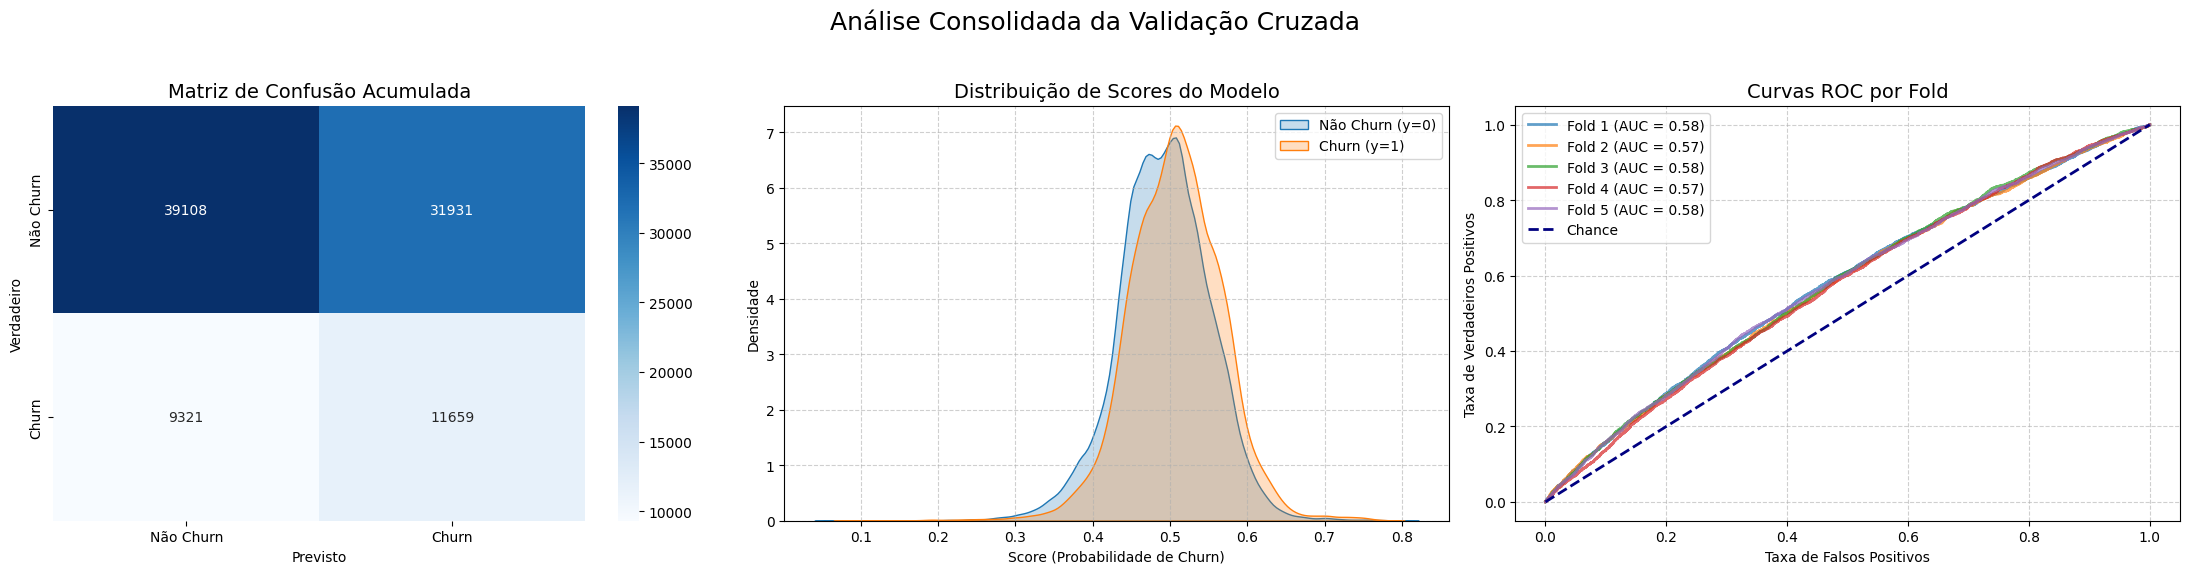

In [118]:
# Usando a função de validação cruzada com o modelo Regressão Logística
validacao_cruzada(X_train, y_train, modelo_regressao, k=5, threshold=0.5, encoder_type='onehot', scaler=True)

- Mesmo depois da tunagem de hiperparâmetros o modelo de Regressão Logística não se saiu muito bem, ele acabou ficando um pouco pior.

#### XGBoost

=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
Precisão: 0.365 | Revocação: 0.760 | F1-Score: 0.494 | ROC AUC: 0.765
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
Precisão: 0.368 | Revocação: 0.718 | F1-Score: 0.487 | ROC AUC: 0.752
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
Precisão: 0.366 | Revocação: 0.739 | F1-Score: 0.489 | ROC AUC: 0.759
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
Precisão: 0.361 | Revocação: 0.726 | F1-Score: 0.482 | ROC AUC: 0.748
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-
Precisão: 0.364 | Revocação: 0.736 | F1-Score: 0.487 | ROC AUC: 0.757

=-=-=-=-=-=- Exibindo a média das métricas obtidas -=-=-=-=-=-=
Média da precisão: 0.365 +/- 0.003
Média da revocação: 0.736 +/- 0.014
Média da acurácia: 0.648 +/- 0.004
Média da Medida F1: 0.488 +/- 0.004
Média da ROC AUC: 0.756 +/- 0.006


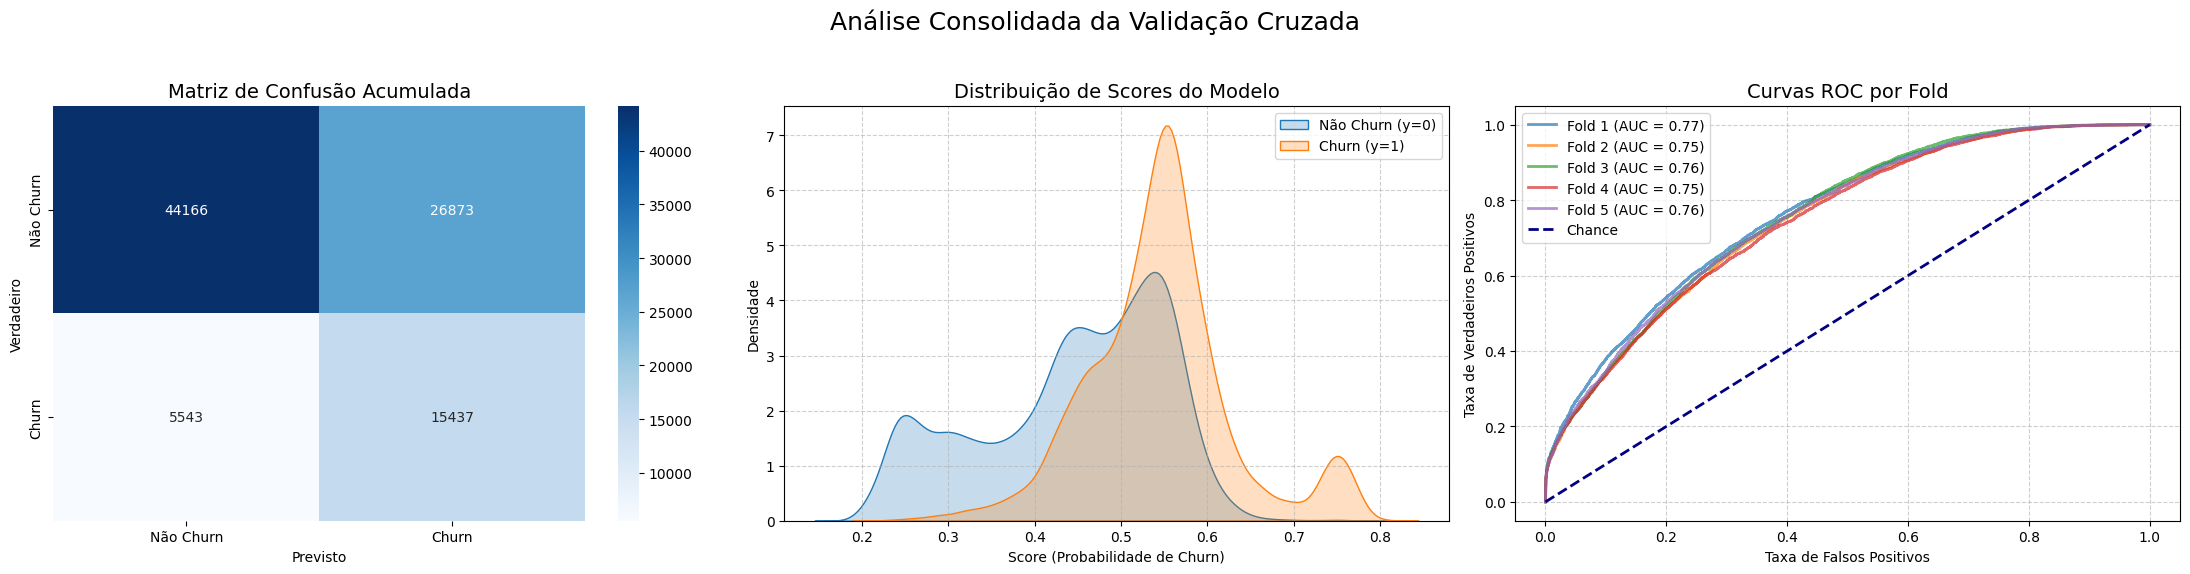

In [51]:
# Usando a função de validação cruzada com o modelo XGBoost
validacao_cruzada(X_train, y_train, modelo_xgboost, k=5, threshold=0.5, encoder_type='catboost', scaler=False)

- Depois da Tunagem de hiperparâmetro o XGBoost melhorou, fazendo com que métrica ROC AUC fique com 0.756.
- Não tivemos muitos clientes churn em que o modelo previu como não churn.

#### LightGBM

=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
Precisão: 0.352 | Revocação: 0.751 | F1-Score: 0.480 | ROC AUC: 0.747
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
Precisão: 0.354 | Revocação: 0.710 | F1-Score: 0.472 | ROC AUC: 0.737
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
Precisão: 0.345 | Revocação: 0.749 | F1-Score: 0.473 | ROC AUC: 0.741
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
Precisão: 0.342 | Revocação: 0.733 | F1-Score: 0.466 | ROC AUC: 0.732
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-
Precisão: 0.344 | Revocação: 0.744 | F1-Score: 0.471 | ROC AUC: 0.738

=-=-=-=-=-=- Exibindo a média das métricas obtidas -=-=-=-=-=-=
Média da precisão: 0.348 +/- 0.005
Média da revocação: 0.738 +/- 0.015
Média da acurácia: 0.624 +/- 0.008
Média da Medida F1: 0.472 +/- 0.004
Média da ROC AUC: 0.739 +/- 0.005


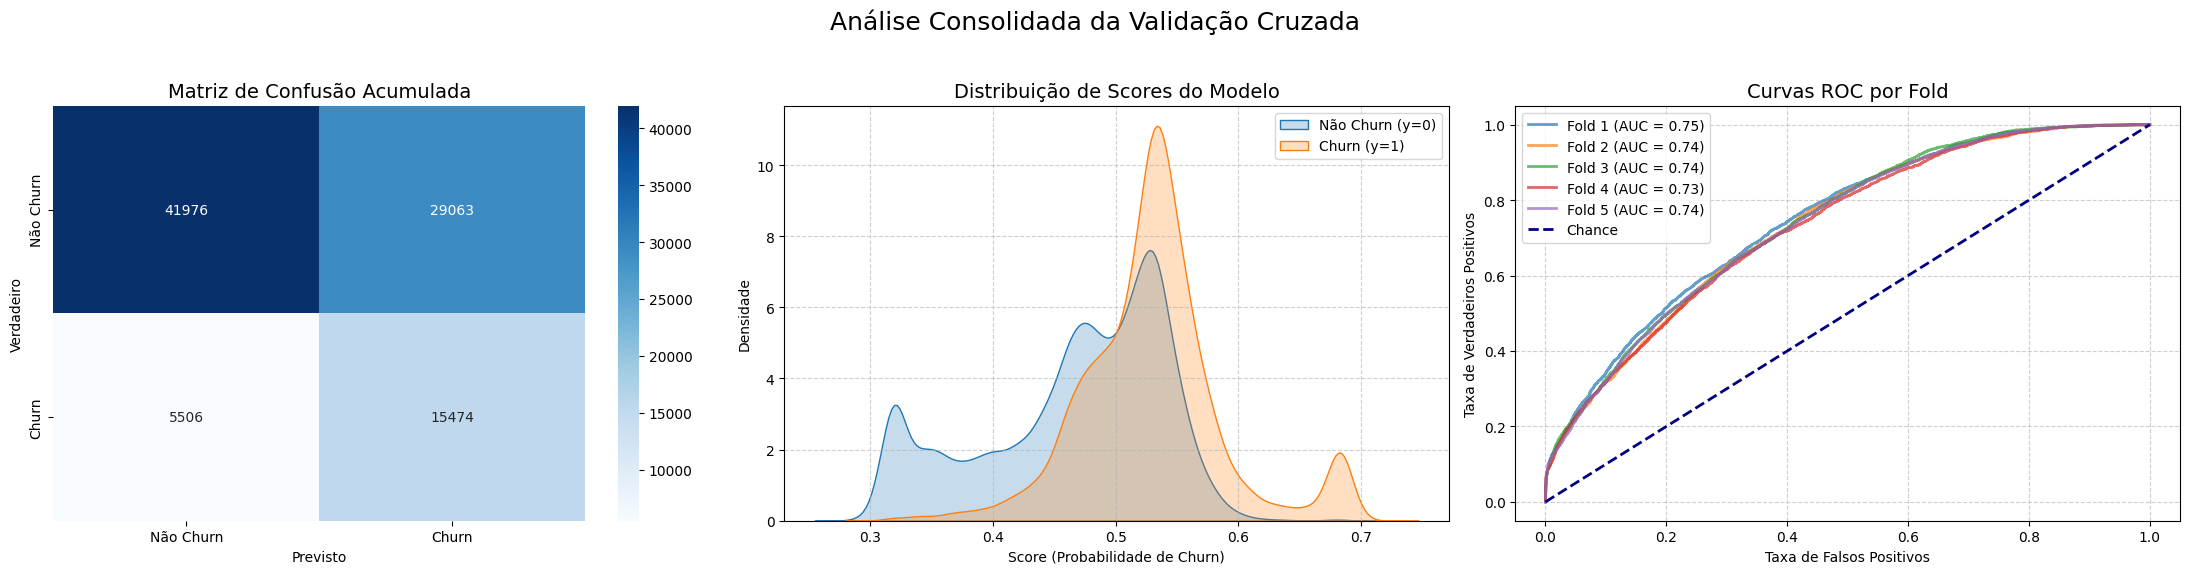

In [52]:
# Usando a função de validação cruzada com o modelo LightGBM
validacao_cruzada(X_train, y_train, modelo_lightgbm, k=5, threshold=0.5, encoder_type='catboost', scaler=False)

- O LightGBM também melhorou depois da tunagem de hiperparâmetro, a métrica ROC AUC ficou com 0.739.
- No momento o modelo XGBoost, é que melhor está prevendo os clientes com churn de acordo com a métrica ROC AUC.

#### CatBoost

=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
Precisão: 0.366 | Revocação: 0.738 | F1-Score: 0.489 | ROC AUC: 0.757
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
Precisão: 0.362 | Revocação: 0.716 | F1-Score: 0.481 | ROC AUC: 0.748
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
Precisão: 0.364 | Revocação: 0.730 | F1-Score: 0.486 | ROC AUC: 0.755
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
Precisão: 0.359 | Revocação: 0.717 | F1-Score: 0.478 | ROC AUC: 0.743
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-
Precisão: 0.364 | Revocação: 0.742 | F1-Score: 0.488 | ROC AUC: 0.751

=-=-=-=-=-=- Exibindo a média das métricas obtidas -=-=-=-=-=-=
Média da precisão: 0.363 +/- 0.002
Média da revocação: 0.729 +/- 0.011
Média da acurácia: 0.646 +/- 0.002
Média da Medida F1: 0.484 +/- 0.004
Média da ROC AUC: 0.751 +/- 0.005


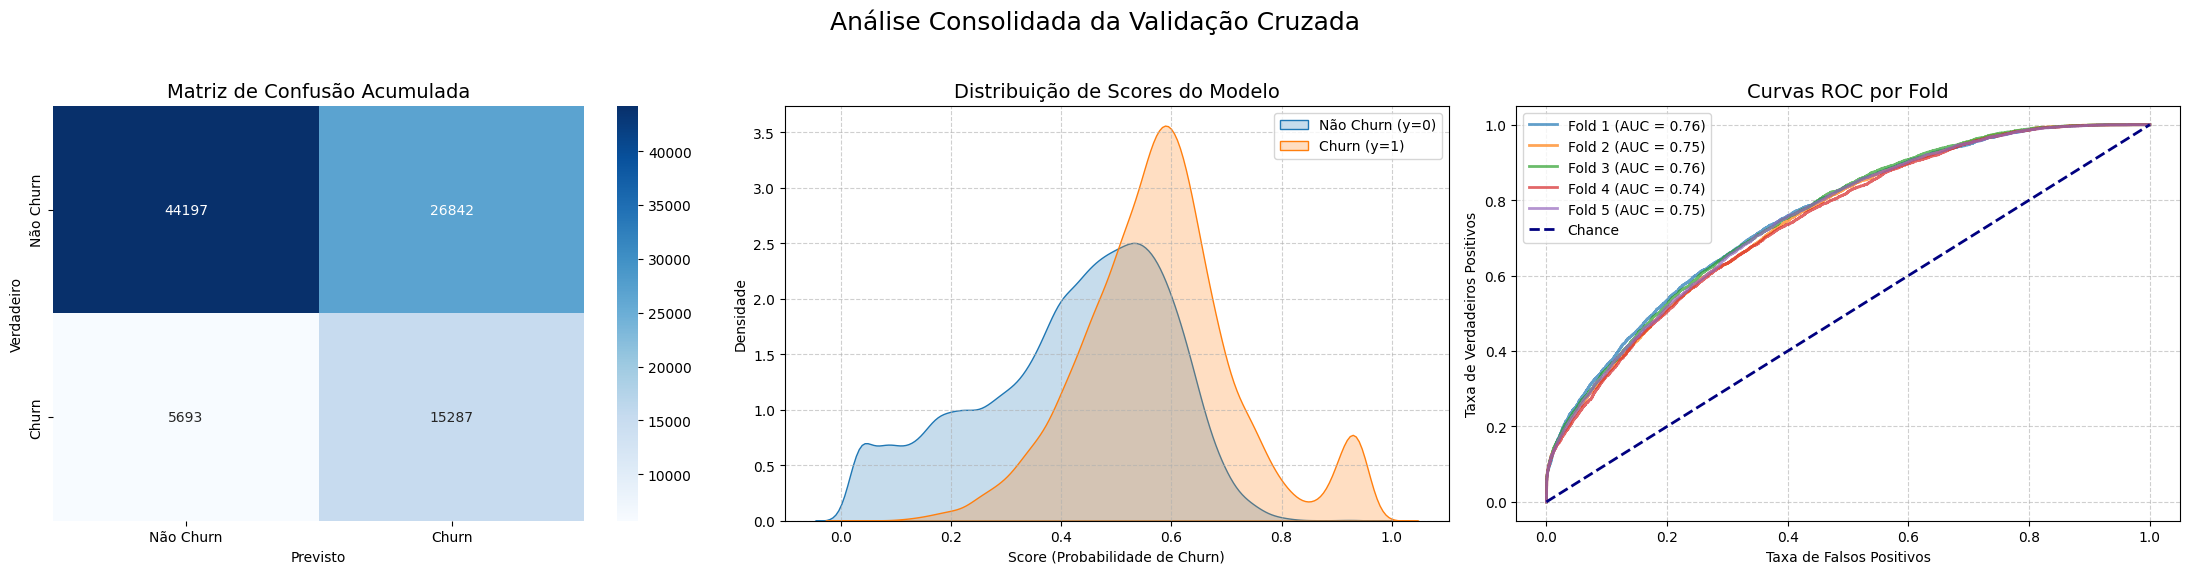

In [53]:
# Usando a função de validação cruzada com o modelo CatBoost
validacao_cruzada(X_train, y_train, modelo_catboost, k=5, threshold=0.5, encoder_type='catboost', scaler=False)

- O CatBoost também melhorou depois da tunagem, sua métrica ROC AUC ficou com 0.751.
- Ele ficou bem próximo do XGBoost de acordo com nossa métrica escolhida para avaliação do melhor modelo.

#### XGBoost como modelo escolhido

Depois de rodar os modelos com os novos hiperparâmetros, o modelo escolhido foi o XGBoost. Ele foi escolhido olhando para a métrica ROC AUC e também pela revocação, não queremos um modelo que prevê como não churn e na verdade é churn (falso positivo).

Agora vamos rodar o modelo XGBoost nos dados de teste e avaliar como ele se comporta em dados que ele nunca viu antes.

=-=-=-=-=-=- Métricas no Conjunto de Teste -=-=-=-=-=-=
Precisão: 0.358
Revocação: 0.721
Acurácia: 0.637
Medida F1: 0.478
ROC AUC: 0.739


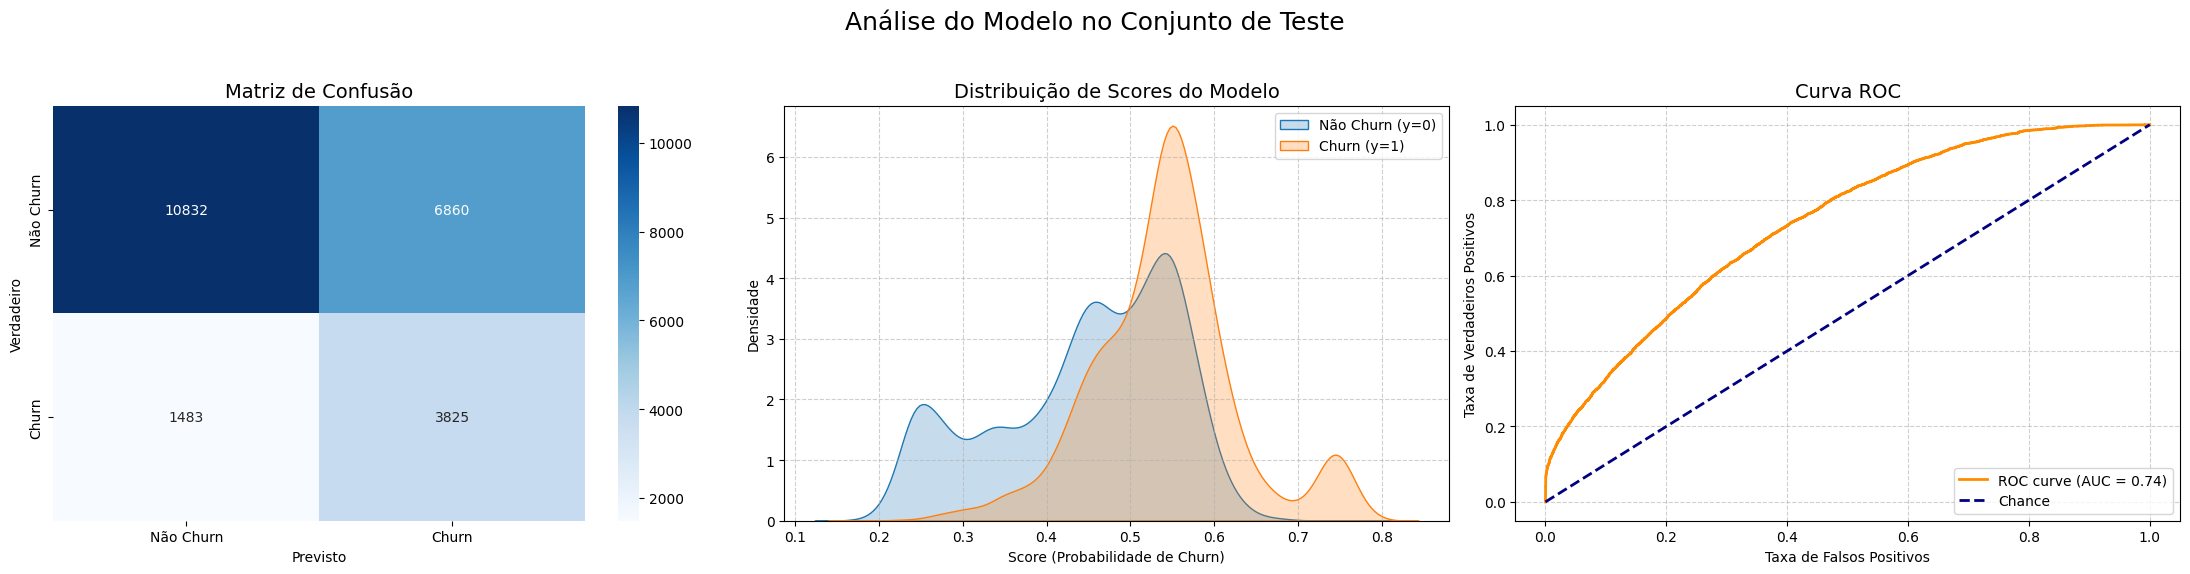

In [98]:
# Separar as colunas categóricas e numéricas
numerical_cols = X_train.select_dtypes(include=np.number).columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

# Pré-processamento para dados numéricos
numerical_transformer = SimpleImputer(strategy='median')

# Pré-processamento para dados categóricos
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', CatBoostEncoder(handle_missing='value', drop_invariant=True))
])

# Pré-processamento de pacotes para dados numéricos e categóricos
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'
)

# Criar o pipeline principal que une o pré-processamento e o modelo
main_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', modelo_xgboost)
])

# Treinar o modelo na base de treino
main_pipeline.fit(X_train, y_train)

# Fazendo as previsões na base de teste
y_proba_test = main_pipeline.predict_proba(X_test)[:, 1]

y_pred = np.where(y_proba_test > 0.5, 1, 0)

# Calcular e exibir as métricas de teste
print("=-"*6 + " Métricas no Conjunto de Teste " + "-="*6)
print(f"Precisão: {precision_score(y_test, y_pred, zero_division=0):.3f}")
print(f"Revocação: {recall_score(y_test, y_pred):.3f}")
print(f"Acurácia: {accuracy_score(y_test, y_pred):.3f}")
print(f"Medida F1: {f1_score(y_test, y_pred):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_test):.3f}")

# --- GERAÇÃO DOS GRÁFICOS ---
fig, axes = plt.subplots(1, 3, figsize=(22, 6))
fig.suptitle('Análise do Modelo no Conjunto de Teste', fontsize=18)

# 1. Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt=".0f", cmap='Blues', ax=axes[0],
            xticklabels=['Não Churn', 'Churn'], yticklabels=['Não Churn', 'Churn'])
axes[0].set_title("Matriz de Confusão", fontsize=14)
axes[0].set_ylabel('Verdadeiro')
axes[0].set_xlabel('Previsto')

# 2. Distribuição de Scores do Modelo
results_df = pd.DataFrame({'y_real': y_test, 'score_modelo': y_proba_test})
sns.kdeplot(results_df[results_df['y_real'] == 0]['score_modelo'], label='Não Churn (y=0)', fill=True, ax=axes[1])
sns.kdeplot(results_df[results_df['y_real'] == 1]['score_modelo'], label='Churn (y=1)', fill=True, ax=axes[1])
axes[1].set_title("Distribuição de Scores do Modelo", fontsize=14)
axes[1].set_xlabel("Score (Probabilidade de Churn)")
axes[1].set_ylabel("Densidade")
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

# 3. Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba_test)
auc_score = roc_auc_score(y_test, y_proba_test)
axes[2].plot(fpr, tpr, lw=2, color='darkorange', label=f'ROC curve (AUC = {auc_score:.2f})')
axes[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
axes[2].set_title('Curva ROC', fontsize=14)
axes[2].set_xlabel('Taxa de Falsos Positivos')
axes[2].set_ylabel('Taxa de Verdadeiros Positivos')
axes[2].legend(loc="lower right")
axes[2].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

- Nosso modelo continuou se saindo bem, com uma métrica ROC AUC 0.739.
- A revocação também ficou com um valor bom, com menos falsos positivos.

#### Utilizando o SHAP para verificar a importância global das features

SHAP (SHapley Additive exPlanations) é uma abordagem baseada na teoria dos jogos para explicar as previsões de qualquer modelo de machine learning. A ideia principal é tratar cada feature como um "jogador" em um jogo, e a previsão do modelo como o "resultado" desse jogo. O SHAP calcula a contribuição justa de cada feature para o resultado final.

A importância global de uma feature no SHAP é definida como a média do impacto absoluto que essa feature tem sobre a previsão do modelo, em todo o conjunto de dados.

Calculando valores SHAP...
Gerando gráficos de diagnóstico SHAP...


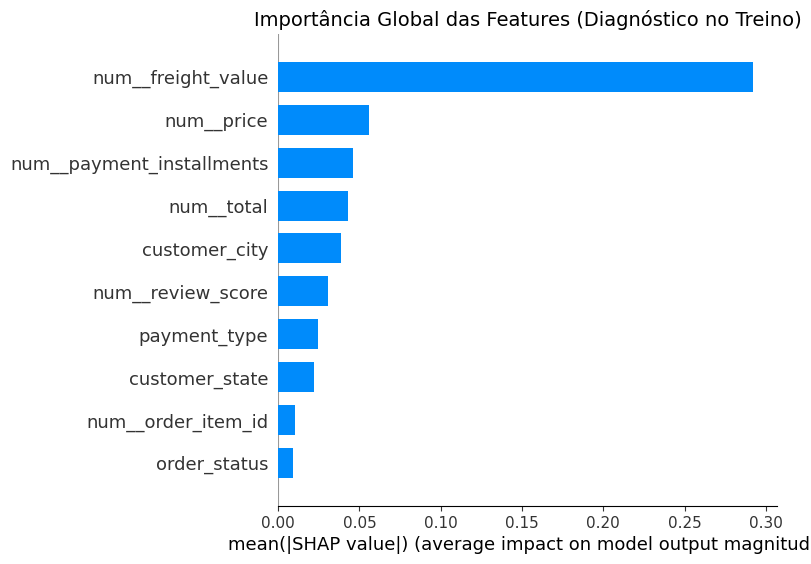

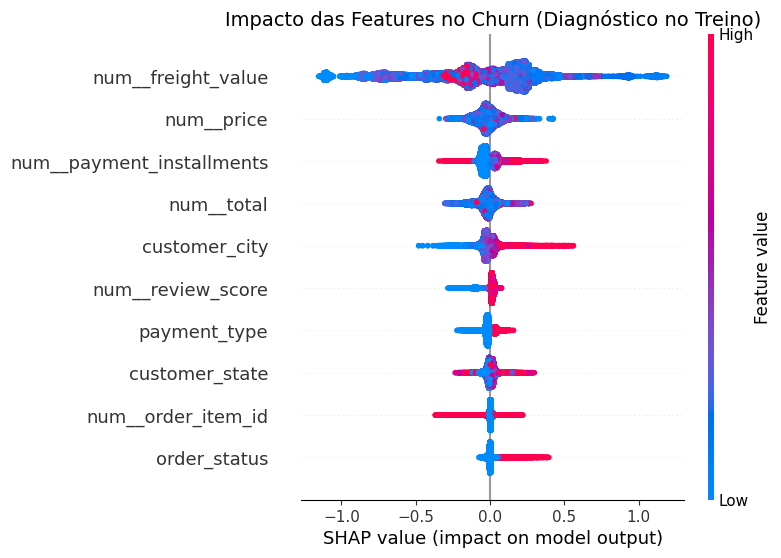

In [75]:
# Separar as colunas categóricas e numéricas
numerical_cols = X_train.select_dtypes(include=np.number).columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

# Pré-processamento para dados numéricos
numerical_transformer = SimpleImputer(strategy='median')

# Pré-processamento para dados categóricos
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', CatBoostEncoder(handle_missing='value'))
])

# Pré-processamento de pacotes para dados numéricos e categóricos
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'
)

# Criar o pipeline principal que une o pré-processamento e o modelo
main_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', modelo_xgboost)
])

# Treinar o modelo na base de treino
main_pipeline.fit(X_train, y_train)

# Análise SHAP
# Extrair os componentes já treinados do modelo
preprocessor_fit = main_pipeline.named_steps['preprocessor']
model_fit = main_pipeline.named_steps['model']

# Transformar os dados de treino para que fiquem no formato que o modelo recebeu
X_train_transformed = preprocessor_fit.transform(X_train)

todas_colunas = ['num__order_item_id', 'num__price', 'num__freight_value',
    'num__payment_installments', 'num__review_score', 'num__total',
    'order_status', 'customer_city', 'customer_state', 'payment_type'
] 
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=todas_colunas, index=X_train.index)

# Calcular os valores SHAP
print("Calculando valores SHAP...")
explainer = shap.TreeExplainer(model_fit)
shap_values = explainer.shap_values(X_train_transformed_df)

# Gerar os Gráficos SHAP
print("Gerando gráficos de diagnóstico SHAP...")

# Gráfico de Importância Global
plt.figure(figsize=(6, 5))
shap.summary_plot(shap_values, X_train_transformed_df, plot_type="bar", show=False)
plt.title("Importância Global das Features (Diagnóstico no Treino)", fontsize=14)
plt.show()

# Gráfico de Densidade de Impacto
plt.figure(figsize=(6, 5))
shap.summary_plot(shap_values, X_train_transformed_df, show=False)
plt.title("Impacto das Features no Churn (Diagnóstico no Treino)", fontsize=14)
plt.show()

- A feature que mais teve impacto na previsão foi o valor do frete, em seguida o preço do produto, o número de parcelas de pagamento, o valor total (frete e preço).
- O que podemos perceber é o que mais está impactando em cliente se tornar churn está atrelado ao valor final do produto e a forma de pagamento.
- Algo que no primeiro momento que poderíamos achar que impactasse era o review score, por ser a avaliação que os clientes deram ao pedido. Mas ele ficou em sexto lugar.

#### O quanto a empresa ganhou ao identificar qual cliente se tornou

##### Calcular as Premissas de Negócio 

Nessa parte vamos definir as variáveis financeiras usando a base de dados de treino. Vamos calcular o Lifetime Value (LTV) Médio, Custo de Ação de Retenção (C_R) e Taxa de Sucesso da Retenção (T_SR).

- O LTV é a receita total que um cliente gera.
- O C_R é uma premissa de negócio, mas podemos baseá-la nos dados. Uma ação de retenção comum é oferecer um cupom de desconto (vamos definir como de 15% de desconto). Vamos o custo desse cupom com base no valor médio dos pedidos.
- A T_SR é também puramente uma premissa de negócio, pois não temos dados de "pós-campanha" para medi-la. Para essa taxa vamos adotar o valor de 30%. Essa é uma estimativa conservadora baseadda em benchmarks de mercado para campanhas de e-commerce que utilizam cupons de desconto para reativar clientes em risco de churn.

In [106]:
# --- Premissa 1: Lifetime Value (LTV) Médio ---
ltv_por_cliente = df_train.groupby('customer_unique_id')['total'].sum()
ltv_medio = ltv_por_cliente.mean()

# --- Premissa 2: Custo da Ação de Retenção (C_R) ---
# Vamos assumir uma campanha com um cupom de 15% sobre o valor médio do pedido
valor_medio_pedido = df_train['total'].mean()
percentual_desconto = 0.15
custo_retencao = valor_medio_pedido * percentual_desconto

# --- Premissa 3: Taxa de Sucesso da Retenção (T_SR) ---
# Esta é uma premissa de negócio
taxa_sucesso_retencao = 0.30

print(f"LTV Médio (LTV): R$ {ltv_medio:.2f}")
print(f"Custo de Retenção por cliente (C_R): R$ {custo_retencao:.2f}")
print(f"Taxa de Sucesso da Retenção (T_SR): {taxa_sucesso_retencao:.0%}")

LTV Médio (LTV): R$ 170.87
Custo de Retenção por cliente (C_R): R$ 21.11
Taxa de Sucesso da Retenção (T_SR): 30%


##### Obter as Previsões

Vamos verificar o desempenho do modelo e consolidar os resultados por cliente.

In [105]:
# Copiando os dados do dataframe de teste para um dataframe de resultados
df_resultados = df_test.copy()

df_resultados['churn_previsto'] = y_pred

# Agrupar por cliente para ter uma linha por cliente e fazer a análise final
df_analise_final = df_resultados.groupby('customer_unique_id').agg(
    churn_real=('churn', 'max'),
    churn_previsto=('churn_previsto', 'max')
).reset_index()

# Calcular a matriz de cofusão
y_real_cliente = df_analise_final['churn_real']
y_previsto_cliente = df_analise_final['churn_previsto']

tn, fp, fn, tp = confusion_matrix(y_real_cliente, y_previsto_cliente).ravel()

print(f"CLIENTES Verdadeiros Positivos (TP): {tp}")
print(f"CLIENTES Falsos Positivos (FP): {fp}")
print(f"CLIENTES Falsos Negativos (FN): {fn}")

CLIENTES Verdadeiros Positivos (TP): 3255
CLIENTES Falsos Positivos (FP): 5859
CLIENTES Falsos Negativos (FN): 1100


##### Calcular o Impacto Financeiro Final

In [108]:
# --- Cenário 1: Perda Total SEM o Modelo ---
# A empresa perderia todos os clientes que realmente deram churn (TP + FN)
clientes_churn_reais = tp + fn
perda_sem_modelo = clientes_churn_reais * ltv_medio

# --- Cenário 2: Resultado COM o Modelo ---

# 1 - Receita Salva: Dos clientes que o modelo previu corretamente (TP), conseguimos salvar uma parte deles (T_SR).
receita_salva = (tp * taxa_sucesso_retencao) * ltv_medio

# 2 - Custo da Campanha: Gastamos dinheiro para tentar reter todos os clientes que o modelo apontou como churn (TP + FP).
custo_campanha = (tp + fp) * custo_retencao

# 3 - Perda Remacescente: Ainda perdemos os clientes que o modelo não conseguiu identificar (FN).
perda_remanescente = fn * ltv_medio

# --- Análise Final: O Valor Gerado pelo Modelo ---
# O valor gerado é o quanto de receita salvamos, menos o custo da campanha.
# Ou de outra forma, é a diferença entre a perda que teríamos e a perda que efetivamente tivemos
valor_gerado_pelo_modelo = perda_sem_modelo - (perda_remanescente + custo_campanha)

# --- Apresentação dos Resultados ---
print("\n--- Análise de Impacto Financeiro ---")
print(f"Cenário SEM Modelo: Perda de R$ {perda_sem_modelo:,.2f}")
print("--------------------------------------------------")
print(f"Cenário COM Modelo:")
print(f"  (+) Receita Salva: R$ {receita_salva:,.2f}")
print(f"  (-) Custo da Campanha de Retenção: R$ {custo_campanha:,.2f}")
print(f"  (-) Perda com Clientes Não Identificados (FN): R$ {perda_remanescente:,.2f}")
print("--------------------------------------------------")
print(f"Resultado Final: O modelo gerou um valor de R$ {valor_gerado_pelo_modelo:,.2f} para a empresa.")


--- Análise de Impacto Financeiro ---
Cenário SEM Modelo: Perda de R$ 744,131.33
--------------------------------------------------
Cenário COM Modelo:
  (+) Receita Salva: R$ 166,852.87
  (-) Custo da Campanha de Retenção: R$ 192,360.49
  (-) Perda com Clientes Não Identificados (FN): R$ 187,955.10
--------------------------------------------------
Resultado Final: O modelo gerou um valor de R$ 363,815.74 para a empresa.


#### Conclusão Final: Geração de Valor Tático e Estratégico
O presente projeto demonstrou a construção de um modelo de churn com um sólido desempenho técnico (ROC AUC 0.74 e Revocação 0.72), capaz de identificar com eficiência os clientes em risco. Para traduzir essa performance em valor de negócio, foi conduzida uma análise de custo-benefício detalhada.

Em um cenário de referência, sem o uso do modelo, a empresa enfrentaria uma perda estimada de R$ 744,131.33. Ao implementar uma campanha de retenção direcionada pelas previsões, o cenário se transforma:

- (+) Receita Salva: R$ 166,852.87
- (-) Custo da Campanha: R$ 192,360.49
- (-) Perda Remanescente (churn não detectado): R$ 187,955.10

Isso resulta em um valor líquido gerado de R$ 363,815.74 para a empresa, provando que a solução de Data Science é financeiramente viável e um investimento estratégico.

No entanto, o valor mias profundo deste trabalho reside na união dessa análise financeira com a interpretabilidade do modelo via SHAP. Descobrimos que o ``valor do frete`` é o principal catalisador do churn. Isso significa que, além dos ganhos reativos, o modelo nos fornece um diagnóstico claro: a maior oportunidade para reduzir o churn de forma sustentável e, consequentemente, diminuir a ```Perda Remanescente`` de r$ 187,955.10, é através de investimentos estratégicos na otimização da malha logística.

Portanto, este projeto entrega uma solução de duplo valor: uma ferramenta tática para reter clientes em risco iminente e um mapa estratégico que apoonta para a causa raiz do problema, permitindo que a empresa aja de forma proativa para fortalecer a lealdade do cliente a longo prazo.